# Analysis of Text Matching Data Generated from JSTOR Dataset 

- [Generating *Middlemarch* chapter and book locations](#Generating-Middlemarch-chapter-and-book-locations)
- [Statistics on our JSTOR dataset](#Statistics-on-our-dataset-of-JSTOR-matches)
    - [Data Dictionary for text matcher dataset](#Data-Dictionary-for-text-matcher-dataset)
    - [How many quotations do we have?](#How-many-quotations-do-we-have?)
    - [How many total articles do we have?](#How-many-total-articles-do-we-have?)
    - [How many articles with matches do we have?](#How-many-articles-with-matches-do-we-have?)
    - [How many articles do we have published in each year?](#How-many-articles-do-we-have-published-in-each-year?)
    - [Number of non-matches in the 6,069-article dataset](#Number-of-non-matches-in-the-6,069-article-dataset)
    - [Average numbers of quoted words per item](#Average-numbers-of-quoted-words-per-item)
    - [Average numbers of quoted words per match, per item](#Average-number-of-words-per-match,-per-item)
    - [Quotation length statistics](#Quotation-Length-Statistics)
- [Functions for extracting wordcounts, numbers of quotations for diachronic and synchronic analysis](#Functions-for-extracting-wordcounts,-numbers-of-quotations-for-diachronic-and-synchronic-analysis)
- [Synchronic Analysis](#Synchronic-Analysis) 
    - [Quotations and Words Quoted Per Book in *Middlemarch*](#Quotations-Per-Book-in-Middlemarch)
    - [Quotes and Words Quoted by Chapter in *Middlemarch*](#Number-of-Quotes-(and-Words-Quoted)-by-Chapter)
- [Diachronic Analysis](#Diachronic-Analysis) 
    - [*Middlemarch* diachronic analysis: quotations per book, by decade](#Middlemarch-diachronic-analysis:-quotations-per-book,-by-decade)
    - [*Middlemarch* diachronic analysis: quotations per chapter,by decade](#Middlemarch-diachronic-analysis:-quotations-per-chapter,-by-decade)
- [*Middlemarch* chapter-specific analysis](#Middlemarch-chapter-specific-analysis)
    - [Chapter 15](#Chapter-15)
    - [Chapter 20](#Chapter-20)
- [*Middlemarch* Quotations, by Journal](#Middlemarch-Quotations,-by-Journal)
    - [Descriptive statistics on journals in JSTOR dataset](#Descriptive-statistics-on-journals-in-JSTOR-dataset)
    - [GE-GHLS, NLH, and ELH](#GE-GHLS,-NLH,-and-ELH)
    - [NLH](#NLH)
    - [ELH](#ELH)
- [Evaluation](#Evaluation)
    - [ Generating samples of dataset for evaluating the precision and recall of text-matcher](#Generating-samples-of-dataset-for-evaluating-the-precision-and-recall-of-text-matcher)
    - [Evaluation metrics](#Evaluation-metrics)


In [170]:
import pandas as pd
import numpy as np
#import spacy
import re
import json
import altair as alt
#new viz library for single-column heatmap
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
#from nltk.corpus import names
from collections import Counter
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [16, 6]
plt.style.use('ggplot')

### Generating *Middlemarch* chapter and book locations 
Here, we're using a Project Gutenberg text of *Middlemarch*, with one modification: the phrase "Book 1" has been moved to appear before the prelude, marking that the "Prelude" is indeed part of the text that appeared with Book 1.

In [172]:
with open('../middlemarch.txt') as f: 
    mm = f.read()

In [173]:
textALength = len(mm) 

In [174]:
# Get chapter locations
chapterMatches = re.finditer('PRELUDE|CHAPTER|FINALE', mm)
chapterLocations = [match.start() for match in chapterMatches]
chapterLocations.append(textALength) # Add one to account for last chunk. 
len(chapterLocations)

89

In [175]:
# Get book locations
bookLocations = [match.start() for match in re.finditer('\nBOOK', mm)]
bookLocations = [0] + bookLocations + [textALength] # Add one to account for last chunk.
bookLocations

[0, 38, 250307, 481579, 681858, 915901, 1138247, 1364956, 1571148, 1793449]

In [176]:
def getChapters(text): 
    chapters = []
    for i, loc in enumerate(chapterLocations): 
        if i != len(chapterLocations)-1: 
            chapter = mm[loc:chapterLocations[i+1]]
            chapters.append(chapter)
    return chapters

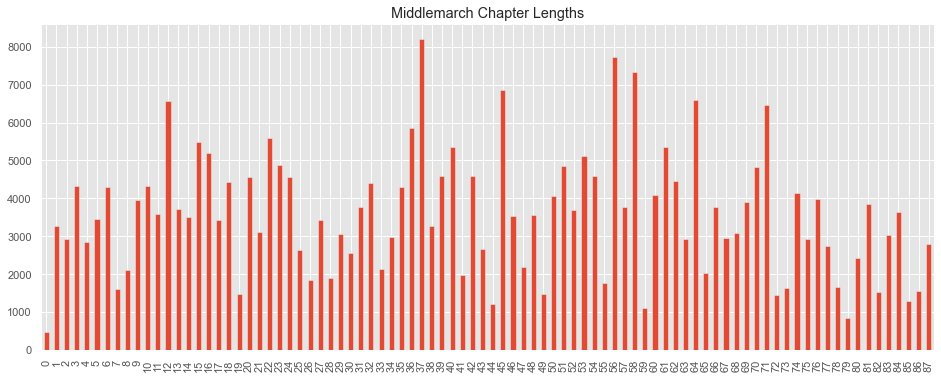

In [177]:
chapters = getChapters(mm)
chapterLengths = [len(chapter.split()) for chapter in chapters]
chapterLengthsSeries = pd.Series(chapterLengths)
chapterLengthsSeries.plot(kind='bar', title='Middlemarch Chapter Lengths')

## Statistics on our dataset of JSTOR matches

### Read in our ` text-matcher` JSTOR data 
Here, we're reading in the output of our text-matcher on our JSTOR data (in JSON format)

In [178]:
df = pd.read_json('../data/e3.json')

In [179]:
df['Decade'] = df['year'] - (df['year'] % 10)
# df['Locations in A'] = df['matches'].apply(lambda x: x[1])
# df['NumMatches'] = df['matches'].apply(lambda x: x[0])

### Data Dictionary for `text matcher` dataset

Our text-matcher dataset includes the following fields:


| Data field | Definition |
| :------------- | :------------- |
| 'Locations in A' | index characters for start and end locations for quoted text in source text (A) [Middlemarch], generated by text-matcher  |
'Locations in B' | index characters for start and end locations for quoted text in the target text (B) [a given JSTOR text], generated by text-matcher  | 
| 'author' | author name supplied by JSTOR | 
| 'coverdate'|  date on cover, supplied by JSTOR |
| 'disc_name' | tags assigned to article, supplied by JSTOR | 
| 'doi' |  text (DOI), supplied by JSTOR | 
| 'id' |  unique identifier, supplied by JSTOR|  
| 'jcode' |  shortcode for journal, supplied by JSTOR |  
| 'journal' |  journal title, supplied by JSTOR | 
| 'la' | language, supplied by JSTO R| 
| 'no' | issue or number,  supplied by JSTOR |  
| 'numMatches'| number of matches, generated by text-matcher |
| 'pages' |  page numbers, supplied by JSTOR | 
| 'publisher_name' |  supplied by JSTOR |  
| 'sp' |  starting page number, supplied by JSTOR | 
| 'srcHtml' |  HTML version of source citation (journal, Volume, issue, date) supplied by JSTOR | 
| 'title' |  title of article or piece of writing, supplied by JSTOR | 
| 'topics' |  subject headings, supplied by JSTOR | 
| 'ty' |  item type (fla = full length article; brv = book review; edi = opinion piece; nws OR mis) = other items, supplied by JSTOR | 
| 'vo' | journal volume, supplied by JSTOR | 
| 'year' |  year of publication, supplied by JSTOR |  
| 'Decade' | decade, generated by Middlematch team from 'year' | 
| 'Quoted Words' | total number of words in all quotations in that text, generated by generated by Middlematch team from "Locations in A' |
| 'Locations in A with Wordcounts': | list of pairs of index characters for start and end quote in the source text (A) [Middlemarch] and wordcount for each quoation, generated by generated by Middlematch team from "Locations in A' 
'Wordcounts' | list of wordcounts for each matched quotation, generated by text-matcher | 

In [186]:
df.columns

Index(['Locations in A', 'Locations in B', 'author', 'coverdate', 'disc_name',
       'doi', 'id', 'jcode', 'journal', 'la', 'no', 'numMatches', 'pages',
       'publisher_name', 'sp', 'srcHtml', 'title', 'topics', 'ty', 'vo',
       'year', 'Decade', 'Quoted Words', 'Locations in A with Wordcounts',
       'Wordcounts'],
      dtype='object')

### How many quotations do we have?

In [180]:
sum([len(item) for item in df['Locations in A'].values])

1794

#### Total number of matches

In [206]:
allMatches = []
for group in df['Locations in A'].values: 
    for pair in group: 
        allMatches.append(pair)

In [207]:
len(allMatches)

1794

### How many total articles do we have? 

In [340]:
print("Total articles with 'Middlemarch' appearing somewhere in text or metadata:")
len(df) # Total articles with "Middlemarch" mentioned somewhere

Total articles with 'Middlemarch' appearing somewhere in text or metadata:


6069

Find only those with non-trivial quotations from Middlemarch: 

In [182]:
articlesWithMatches = df[df['Locations in A'].apply(lambda x: len(x) > 0)]
articlesWithMatches.year.describe()

count     489.000000
mean     1991.871166
std        18.477106
min      1873.000000
25%      1980.000000
50%      1995.000000
75%      2007.000000
max      2016.000000
Name: year, dtype: float64

### How many articles with matches do we have? 

In [341]:
print("Number of articles with matches to text in 'Middlemarch':")
articlesWithMatches['Locations in A'].count()

Number of articles with matches to text in 'Middlemarch':


489

In [183]:
articlesWithMatches.Wordcounts.apply(len).head()

0    17
3     3
4     3
8     3
9    12
Name: Wordcounts, dtype: int64

In [184]:
# articlesWithMatches.to_json('../data/cleaned-matches.json')

### How many articles do we have published in each year? 
Here, we're looking just at the 489 articles with matches

In [346]:
alt.Chart(articlesWithMatches, title="Number of JSTOR articles with detected Middlemarch matches, by year").mark_bar().encode(x='year:O', y='count()').properties(width=1000)

alt.Chart(...)

### Number of non-matches in the 6,069-article dataset
One reason  the 6,069-article original dataset is so much larger has to do with the way JSTOR ingests paratextual matter from journals. We found appearance of the word "middlemarch" in paratextual matter, which was systemattically titled in JSTOR. Here we define a quick function to count the number of appearances of article-like paratextual matter: "front matter", "back matter", "table of contents" and "cover".

None of these titles are present in the smaller dataset of matches.

#### Nonmatches

In [331]:
# Try to find out what articles contain no Middlemarch citations
articlesWithoutMatches = df[df['Locations in A'].apply(lambda x: len(x) == 0)]

In [332]:
n = 10
articlesWithoutMatches['title'].value_counts()[:n].index.tolist()

[['Back Matter'],
 ['Front Matter'],
 ['Volume Information'],
 ['Summary of Periodical Literature'],
 ['Recent Studies in the Nineteenth Century'],
 ['Books Received'],
 ['List of Publications Received'],
 ['Recent Books'],
 ['Abstracts'],
 ['Review']]

In [333]:
# What is the most frequent name of articles with no citations?
articlesWithoutMatches['title'].describe()

count              4427
unique             3645
top       [Back Matter]
freq                208
Name: title, dtype: object

In [188]:
def isGarbage(itemTitle): 
    badTitles = ['front matter', 'back matter', 'table of contents', 'cover']
    if itemTitle == None: 
        return False
    for title in itemTitle: 
        for badTitle in badTitles: 
            if badTitle in title.lower(): 
                return True
    return False

In [493]:
print("Number of'front matter', 'back matter', 'table of contents', 'cover' items in the 6069-article JSTOR dataset:")
len(df[df.title.apply(isGarbage)]) # How many garbage items? 

Number of'front matter', 'back matter', 'table of contents', 'cover' items in the 6069-article JSTOR dataset:


457

### Average numbers of quoted words per item

In [190]:
df['Quoted Words'].describe()

count    6069.000000
mean       19.240896
std       105.153455
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      2498.000000
Name: Quoted Words, dtype: float64

In [348]:
print('Statistics on average, min, and max number of quoted words per item:')
articlesWithMatches['Quoted Words'].describe()

Statistics on average, min, and max number of quoted words per item:


count     489.000000
mean      238.799591
std       291.466263
min        13.000000
25%        68.000000
50%       141.000000
75%       281.000000
max      2498.000000
Name: Quoted Words, dtype: float64

In [192]:
len(df[df['Quoted Words'] > 0])

489

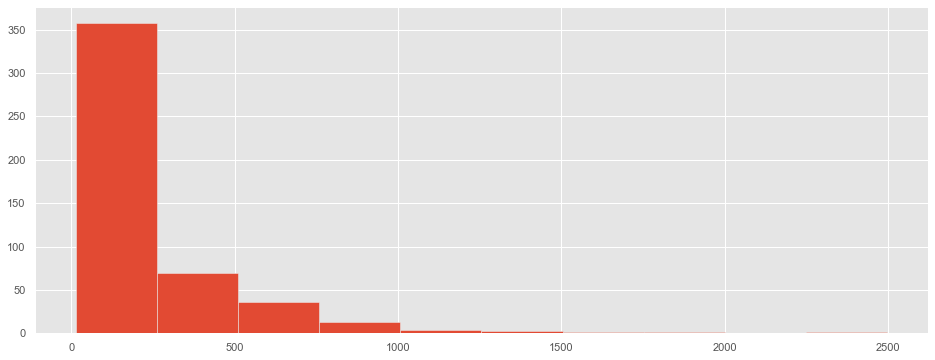

In [193]:
articlesWithMatches['Quoted Words'].hist()

### Average number of words per match, per item: 

Average number of words per match, per item: 

In [347]:
print('Average number of words per match, per item:')
articlesWithMatches['Wordcounts'].apply(np.mean).head()

Average number of words per match, per item:


0     67.235294
3     23.666667
4    167.000000
8     47.333333
9     62.416667
Name: Wordcounts, dtype: float64

In [349]:
print('Statistics on average number of words, min/max per match, per item:')
articlesWithMatches['Wordcounts'].apply(np.mean).describe()

Statistics on average number of words, min/max per match, per item:


count    489.000000
mean      69.712270
std       50.153803
min       13.000000
25%       37.000000
50%       58.500000
75%       86.000000
max      435.333333
Name: Wordcounts, dtype: float64

### Quotation Length Statistics

In [201]:
df['Wordcounts'] = df['Locations in A with Wordcounts'].apply(extractWordcounts)

In [202]:
wordcounts = []
for countSet in df['Wordcounts'].values: 
    for count in countSet: 
        wordcounts.append(count)

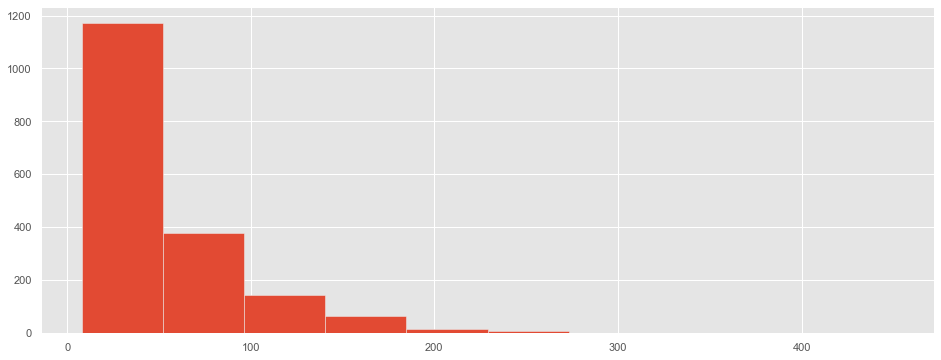

In [203]:
pd.Series(wordcounts).hist()

### Functions for extracting wordcounts, numbers of quotations for diachronic and synchronic analysis

In [196]:
def diachronicAnalysis(df, decades=(1950, 2020), bins=chapterLocations, useWordcounts=True, normalize=True):
    """ Turning on useWordcounts makes it so that it's weighted by wordcount. 
    Turning it off uses raw numbers of quotations. """
    decades = np.arange(decades[0], decades[1], 10)
    # Make a dictionary of decades. 
    # Values are a list of locations.  
    decadeDict = {}
    for i, row in df.iterrows():
        decade = row['Decade']
        locationsAndWordcounts = row['Locations in A with Wordcounts']
        if decade not in decadeDict: 
            decadeDict[decade] = locationsAndWordcounts.copy()
        else: 
            decadeDict[decade] += locationsAndWordcounts.copy()
    # Grab the beginnings of quotes. 
    decadeStartsWeights = {decade: [(item[0][0], item[1]) 
                                    for item in loc] 
                    for decade, loc in decadeDict.items()}
    if useWordcounts: 
        decadesBinned = {decade: 
                     np.histogram([loc[0] for loc in locations], 
                                  bins=bins,
                                  weights=[loc[1] for loc in locations],
                                  range=(0, textALength))[0]
                     for decade, locations in decadeStartsWeights.items() 
                         if decade in decades}
    else: 
        decadesBinned = {decade: 
                     np.histogram([loc[0] for loc in locations], 
                                  bins=bins,
                                  range=(0, textALength))[0]
                     for decade, locations in decadeStartsWeights.items() 
                         if decade in decades}
    decadesDF = pd.DataFrame(decadesBinned).T
    #Normalize
    if normalize: 
        decadesDF = decadesDF.div(decadesDF.max(axis=1), axis=0)
    return decadesDF

def countWords(locRange): 
    """ Counts words in middlemarch, given character ranges. """
    chunk = mm[locRange[0]:locRange[1]]
    return len(chunk.split())

def totalWords(locRangeSet): 
    """ Counts total words in a list of location ranges. """
    return sum([countWords(locRange) for locRange in locRangeSet])    
    
def countsPerSet(locRangeSet): 
    """ Returns an augmented location range set that includes word counts. """
    return [(locRange, countWords(locRange))
             for locRange in locRangeSet]
    
def extractWordcounts(locsAndWordcounts): 
    """ 
    Takes pairs of location ranges and wordcounts, 
    and returns just the wordcounts. 
    """
    return [item[1] for item in locsAndWordcounts 
            if len(locsAndWordcounts) > 0]

def synchronicAnalysis(df, bins=chapterLocations, useWordcounts=True): 
    locs = df['Locations in A'].values
    locCounts = [(loc, countWords(loc)) for locSet in locs
              for loc in locSet]
    starts = [loc[0][0] for loc in locCounts]
    counts = [loc[1] for loc in locCounts]
    if useWordcounts: 
        binned = np.histogram(starts, bins=bins, 
                              weights=counts, range=(0, textALength))
    else: 
        binned = np.histogram(starts, bins=bins, 
                              range=(0, textALength))
    binnedDF = pd.Series(binned[0])
    return binnedDF

def plotDiachronicAnalysis(df, save=False, reverse=False): 
    ylabels = [str(int(decade)) for decade in df.index] + ['2020']
    plt.pcolor(df, cmap='gnuplot')
    plt.yticks(np.arange(len(df.index)+1), ylabels)
    plt.gca().invert_yaxis()
    plt.ylabel('Decade')
    plt.xlabel('Chapter')
    plt.gca().set_xlim((0, len(df.T)))
    plt.colorbar(ticks=[])
    if save: 
        plt.savefig('diachronic.png', bboxinches='tight', dpi=300, transparent=True)
    plt.show()
    
def plotSynchronicAnalysis(s, useWordcounts=True): 
    ax = s.plot(kind='bar')
    ax.set_xlabel('Chapter')
    if useWordcounts: 
        ax.set_ylabel('Number of Words Quoted')
    else: 
        ax.set_ylabel('Number of Quotations')
        
def plotSynchronicAnalysisHeatmap(s, useWordcounts=True): 
    vec1=synchronicAnalysis(df, useWordcounts=False)
    fig, ax = plt.subplots()
    sns.color_palette("magma")
    sns.heatmap([vec1])
    ax.set_xlabel('Chapter')
    ax.set_ylabel('Number of Quotations')
    
def plotDiachronicAnalysisBubble(df, save=False, reverse=False):
    ylabels = [str(int(decade)) for decade in df.index] + ['2020'] 
    alt.Chart(df).mark_circle().encode(
    x='Chapter',
    y='Decade',
    size='sum(count):Q'
)

### Adding additional rows to DataFrame

In [197]:
df['Quoted Words'] = df['Locations in A'].apply(totalWords)

In [198]:
df['Locations in A with Wordcounts'] = df['Locations in A'].apply(countsPerSet)

In [199]:
# Verify that the diachronic wordcounts are the same as the synchronic wordcounts
decadeSums = diachronicAnalysis(df, decades=(1700, 2020), useWordcounts=True, normalize=False).sum(axis=1)
decadeSums.sum()

94671.0

In [200]:
chapterSums = synchronicAnalysis(df)
chapterSums.sum()

94671

# Synchronic Analysis

In these next sections, we're going to look at the "Book" and chapter level quotation counts for the entire dataset of text-matcher data.

- [Quotations and Words Quoted Per Book in Middlemarch](#Quotations-Per-Book-in-Middlemarch)
    - [Number of words quoted per book in Middlemarch, bar chart](#Number-of-words-quoted-per-book-in-Middlemarch,-bar-chart)
    - [Number of words quoted per book in Middlemarch, bubble chart](#Number-of-words-quoted-per-book-in-Middlemarch,-bubble-chart)
    - [Number of quotations per book in Middlemarch, bar chart](#Number-of-quotations-per-book-in-Middlemarch,-bar-chart)
    - [Number of quotations per book in Middlemarch, bubble chart](#Number-of-quotations-per-book-in-Middlemarch,-bubble-chart)
- [Quotes and Words Quoted by Chapter in Middlemarch](#Number-of-Quotes-(and-Words-Quoted)-by-Chapter)
	- [Number of words quoted, by chapter in Middlemarch](#Number-of-words-quoted,-by-chapter-in-Middlemarch)
	- [Number of quotations, by chapter in Middlemarch, bar chart](#Number-of-quotations,-by-chapter-in-Middlemarch,-bar-chart)
	- [Number of quotations, by chapter in Middlemarch, bubble chart](#Number-of-quotations,-by-chapter-in-Middlemarch,-bubble-chart)
	- [Normalized number of words quoted per chapter](#Normalized-number-of-words-quoted-per-chapter)
    

## Quotations Per Book in *Middlemarch*

### Number of words quoted per book in *Middlemarch*

In [371]:
wordsQuotedPerBook = synchronicAnalysis(df, bins=bookLocations, useWordcounts=True)
wordsQuotedPerBook

0        0
1    22444
2    24746
3    10105
4     8996
5     6110
6     5222
7     2030
8    15538
dtype: int64

In [375]:
wordsQuotedPerBook = pd.DataFrame(wordsQuotedPerBook, index=range(1,9), columns=['Number of Words Quoted'])
wordsQuotedPerBook['Book'] = range(1, 9)
wordsQuotedPerBook

,Number of Words Quoted,Book
1,22444,1
2,24746,2
3,10105,3
4,8996,4
5,6110,5
6,5222,6
7,2030,7
8,15538,8


### Number of words quoted per book in *Middlemarch*, bar chart

In [377]:
alt.Chart(wordsQuotedPerBook, title="Number of Words Quoted, per Book in Middlemarch").\
mark_bar().encode(x=alt.X('Book:O', axis=alt.Axis(title="Book", labelAngle=0)), y='Number of Words Quoted:Q').\
properties(width=500)

alt.Chart(...)

### Number of words quoted per book in *Middlemarch*, bubble chart

In [378]:
# Bubble chart with horizontal labels
alt.Chart(wordsQuotedPerBook, title="Number of Words Quoted, per Book in Middlemarch").mark_circle().encode(x=alt.X('Book:O', axis=alt.Axis(title="Book", labelAngle=0,)), 
size=alt.Size('Number of Words Quoted:Q')).properties(height=150).configure_legend(
    titleFontSize=12,
    labelFontSize=12
)

alt.Chart(...)

### Number of quotations per book in *Middlemarch*

In [215]:
quotationsPerBook = synchronicAnalysis(df, bins=bookLocations, useWordcounts=False)
quotationsPerBook

0      0
1    475
2    460
3    164
4    171
5    111
6    104
7     49
8    260
dtype: int64

In [216]:
quotationsPerBook = pd.DataFrame(quotationsPerBook, index=range(1,9), columns=['Number of Quotations'])
quotationsPerBook['Book'] = range(1, 9)
quotationsPerBook

,Number of Quotations,Book
1,475,1
2,460,2
3,164,3
4,171,4
5,111,5
6,104,6
7,49,7
8,260,8


### Number of quotations per book in *Middlemarch*, bar chart

In [365]:
alt.Chart(quotationsPerBook, title="Number of Quotations, per Book in Middlemarch").\
mark_bar().encode(x=alt.X('Book:O', axis=alt.Axis(title="Book", labelAngle=0)), y='Number of Quotations:Q').\
properties(width=500)

alt.Chart(...)

### Number of quotations per book in *Middlemarch*, bubble chart

In [368]:
# Bubble chart with horizontal labels
alt.Chart(quotationsPerBook, title="Number of Quotations, per Book in Middlemarch").mark_circle().encode(x=alt.X('Book:O', axis=alt.Axis(title="Book", labelAngle=0,)), 
size=alt.Size('Number of Quotations:Q')).properties(height=150).configure_legend(
    titleFontSize=12,
    labelFontSize=12
)

alt.Chart(...)

## Number of Quotes (and Words Quoted) by Chapter

### Number of words quoted, by chapter in *Middlemarch*

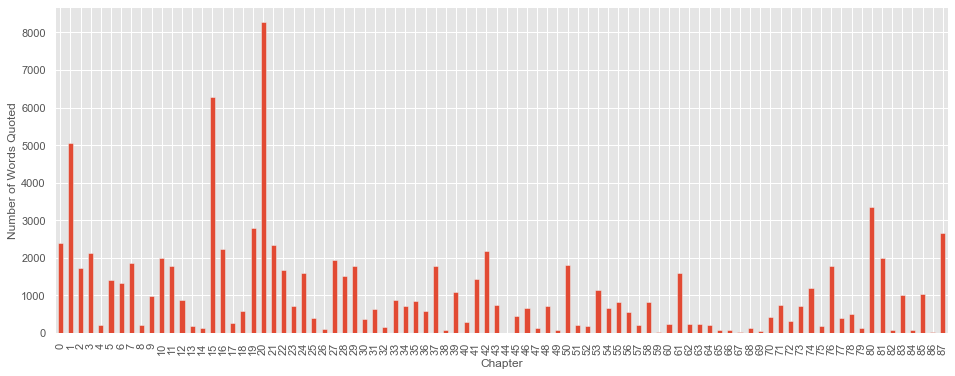

In [204]:
plotSynchronicAnalysis(synchronicAnalysis(df))

In [205]:
synchronicAnalysis(df, useWordcounts=True).to_csv('../papers/spring2017-middlemarch-paper/data/num-words-quoted-per-chapter.csv')

In [ ]:
wordsQuotedPerChapter = synchronicAnalysis(df, bins=chapterLocations, useWordcounts=True)

In [355]:
wordsQuotedPerChapter = pd.DataFrame(wordsQuotedPerChapter, index=range(0,88), columns=['Number of Words Quoted'])
wordsQuotedPerChapter['Chapter'] = range(0, 88)
wordsQuotedPerChapter

,Number of Words Quoted,Chapter
0,2396,0
1,5046,1
2,1719,2
3,2129,3
4,210,4
5,1406,5
6,1335,6
7,1854,7
8,203,8
9,974,9


### Number of quotations, by chapter in *Middlemarch*, bar chart

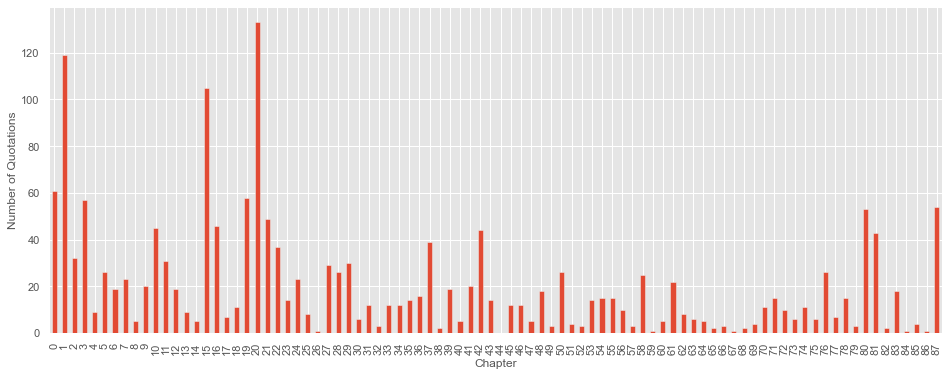

In [208]:
plotSynchronicAnalysis(synchronicAnalysis(df, useWordcounts=False), useWordcounts=False)

In [ ]:
quotationsPerChapter = synchronicAnalysis(df, bins=chapterLocations, useWordcounts=False)

In [210]:
quotationsPerChapter = pd.DataFrame(quotationsPerChapter, index=range(0,88), columns=['Number of Quotations'])
quotationsPerChapter['Chapter'] = range(0, 88)
quotationsPerChapter

,Number of Quotations,Chapter
0,61,0
1,119,1
2,32,2
3,57,3
4,9,4
5,26,5
6,19,6
7,23,7
8,5,8
9,20,9


### Number of quotations, by chapter in *Middlemarch*, bubble chart

In [213]:
# Redo chart with horizontal labels
alt.Chart(quotationsPerChapter).mark_circle().encode(x=alt.X('Chapter:Q', axis=alt.Axis(title="Chapter", tickMinStep=5,
                                       labelOverlap=False,labelAngle=0)), 
size=alt.Size('Number of Quotations:Q', scale=alt.Scale(range=[1, 1000]))).properties(width=1000,height=150).configure_legend(
    titleFontSize=9,
    labelFontSize=10
)

alt.Chart(...)

In [214]:
alt.Chart(quotationsPerChapter).mark_circle().encode(y='Chapter:O', size=alt.Size('Number of Quotations:Q', scale=alt.Scale(range=[1, 1000]))).properties(width=150)

alt.Chart(...)

### Normalized number of words quoted per chapter

In [220]:
# Get the raw number of quotations per chapter
# synchronicAnalysis(df, useWordcounts=False).to_csv('../papers/spring2017-middlemarch-paper/data/num-quotations-per-chapter.csv')

Text(0, 0.5, 'Words Quoted, Normalized')

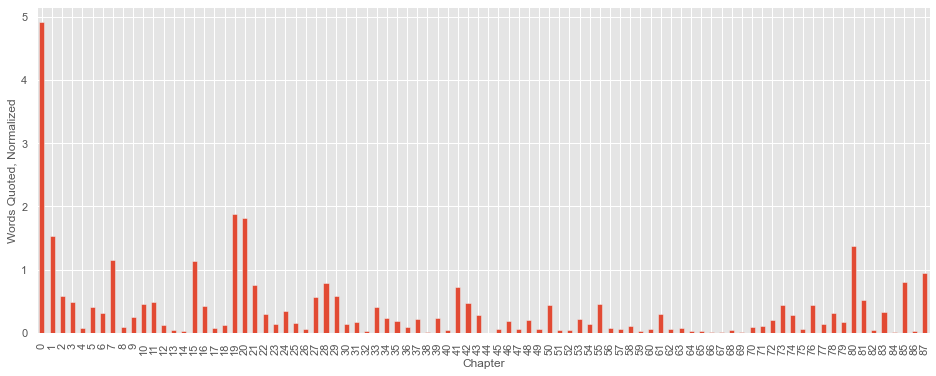

In [221]:
# Adjusted for the number of words in each chapter
ax = (synchronicAnalysis(df) / chapterLengthsSeries).plot(kind='bar')
ax.set_xlabel('Chapter')
ax.set_ylabel('Words Quoted, Normalized')

# Diachronic Analysis

For the diachronic analysis, we examine book- and chapter-level data for quotations from *Middlemarch*. 

- [Middlemarch diachronic analysis: quotations per book, by decade](#Middlemarch-diachronic-analysis:-quotations-per-book,-by-decade)
    - [Number of quotations per book, per decade (not normalized or weighted)](#Number-of-quotations-per-book,-per-decade-(not-normalized-or-weighted))
    - [Number of quotations per book, per decade (normalized by decade)](#Number-of-quotations-per-book,-per-decade-(normalized-by-decade))
    - [Number of quotations per book, per decade (normalized by decade and weighted by word count)](#Number-of-quotations-per-book,-per-decade-(normalized-by-decade-and-weighted-by-word-count))
    - [Middlemarch quotations per book, per decade (normalized-and-weighted), heatmap](#Middlemarch-quotations-per-book,-per-decade-(normalized-and-weighted),-heat-map)
    - [Middlemarch quotations per book, per decade (normalized-and-weighted), table bubble plots](#Middlemarch-quotations-per-book,-per-decade-(normalized-and-weighted),-table-bubble-plots)
- [ Middlemarch diachronic analysis: quotations per chapter,by decade](#Middlemarch-diachronic-analysis:-quotations-per-chapter,-by-decade)
    - [Number of quotations per chapter, per decade (not normalized or weighted)](#Number-of-quotations-per-chapter,-per-decade-(not-normalized-or-weighted))
    - [Number of quotations per chapter, per decade (normalized by decade and weighted by word count)](#Number-of-quotations-per-chapter,-per-decade-(normalized-by-decade-and-weighted-by-word-count))
    - [Middlemarch quotations per chapter, per decade (normalized and weighted), heat map](#Middlemarch-quotations-per-chapter,-per-decade-(normalized-and-weighted),-heat-map)
    - [Middlemarch quotations per chapter, per decade (normalized and weighted), table bubble plots](#Middlemarch-quotations-per-chapter,-per-decade-(normalized-and-weighted),-table-bubble-plots)

## *Middlemarch* diachronic analysis: quotations per book, by decade

We use three different methods to analyze quotations per book, by decade. First, we examine the raw counts of quotations per book, per decade. Because our corpus contains [varying numbers of JSTOR texsts per decade](#How-many-articles-do-we-have-published-in-each-year?), we've decided to also weigh by length of quotation and normalize per decade.

### Number of quotations per book, per decade (not normalized or weighted)

In [410]:
# Raw quotation counts (not weighted by the number of words in the quoatation or normalized by decade)
# Turning on useWordcounts makes it so that it's weighted by wordcount. Turning it off uses raw numbers of quotations.
booksNotNormalizedNotWeightedDiaDF = diachronicAnalysis(df, decades=(1960, 2020), bins=bookLocations,\
                                                        useWordcounts=False, normalize=False).sort_index()
print('Number of quotations per book, per decade')
booksNotNormalizedNotWeightedDiaDF

Number of quotations per book, per decade


,0,1,2,3,4,5,6,7,8
1960,0,28,31,5,14,17,3,7,22
1970,0,59,47,17,17,15,11,3,20
1980,0,76,81,20,26,8,21,6,42
1990,0,94,109,25,50,17,11,6,59
2000,0,114,98,49,30,35,33,9,35
2010,0,82,68,42,30,13,21,13,56


In [398]:
booksNotNormalizedNotWeightedDiaDF['decade'] = booksNotNormalizedNotWeightedDiaDF.index

In [399]:
booksNotNormalizedNotWeightedDiaDFMelted = booksNotNormalizedNotWeightedDiaDF.melt(id_vars='decade', var_name='book')

In [407]:
# cut out erroneous "book 0" material (ie title page)
booksNotNormalizedNotWeightedDiaDFMelted = booksNotNormalizedNotWeightedDiaDFMelted[booksNotNormalizedNotWeightedDiaDFMelted.book != 0]

In [431]:
booksNotNormalizedNotWeightedDiaDFMeltedExport = booksNotNormalizedNotWeightedDiaDFMelted.rename(columns={"value": "Number of Quotations"})
# To export a CSV, uncomment the line below
# booksNotNormalizedNotWeightedDiaDFMeltedExport.to_csv("Middlemarch-quotations-per-book-per-decade-not-weighted-or-normalized.csv")

In [434]:
alt.Chart(booksNotNormalizedNotWeightedDiaDFMelted,\
          title="Middlemarch quotations per book, per decade (not weighted or normalized)")\
.mark_rect().encode(x='book:O', y='decade:O', color=alt.Color('value', legend=alt.Legend(title="Number of Quotations"))).properties(width=500, height=300)

alt.Chart(...)

### Number of quotations per book, per decade (normalized by decade)

In [392]:
# Number of quotations (not weighted), normalized by decade(counts are scaled to the maximum value per decade)
booksNotWeightedDiaDF = diachronicAnalysis(df, decades=(1960, 2020), bins=bookLocations, useWordcounts=False, normalize=True).sort_index()
print('Quotations per book, per decade (normalized by decade):')
booksNotWeightedDiaDF

Quotations per book, per decade (normalized by decade):


,0,1,2,3,4,5,6,7,8
1960,0.0,0.903226,1.000000,0.161290,0.451613,0.548387,0.096774,0.225806,0.709677
1970,0.0,1.000000,0.796610,0.288136,0.288136,0.254237,0.186441,0.050847,0.338983
1980,0.0,0.938272,1.000000,0.246914,0.320988,0.098765,0.259259,0.074074,0.518519
1990,0.0,0.862385,1.000000,0.229358,0.458716,0.155963,0.100917,0.055046,0.541284
2000,0.0,1.000000,0.859649,0.429825,0.263158,0.307018,0.289474,0.078947,0.307018
2010,0.0,1.000000,0.829268,0.512195,0.365854,0.158537,0.256098,0.158537,0.682927


### Number of quotations per book, per decade (normalized by decade and weighted by word count)

In [390]:
# Weighted by wordcount (by the number of words in the quotation) and normalized by decade(counts are scaled to the maximum value per decade)
booksDiaDF = diachronicAnalysis(df, decades=(1960, 2020), bins=bookLocations, useWordcounts=True, normalize=True).sort_index()
print('Quotations per book, per decade (weighted by length of quotation and normalized by decade):')
booksDiaDF

Quotations per book, per decade (weighted by length of quotation and normalized by decade):


,0,1,2,3,4,5,6,7,8
1960,0.0,0.484480,1.000000,0.184983,0.309983,0.526007,0.044463,0.122903,0.524329
1970,0.0,1.000000,0.881306,0.383119,0.334652,0.156940,0.195516,0.013848,0.475107
1980,0.0,0.861341,1.000000,0.257013,0.284798,0.085760,0.308576,0.092439,0.867219
1990,0.0,0.787806,1.000000,0.220851,0.530300,0.117517,0.082151,0.069442,0.538405
2000,0.0,1.000000,0.976565,0.672464,0.340168,0.391798,0.375320,0.057305,0.452398
2010,0.0,1.000000,0.813368,0.564133,0.303601,0.224523,0.149682,0.112497,0.675688


In [247]:
booksDiaDF['decade'] = booksDiaDF.index

In [248]:
booksMelted = booksDiaDF.melt(id_vars='decade', var_name='book')

In [394]:
# cut out erroneous "book 0" material (ie title page)
booksMelted = booksMelted[booksMelted.book != 0]

### *Middlemarch* quotations per book, per decade (normalized and weighted), heat map

In [443]:
alt.Chart(booksMelted,\
          title="Middlemarch quotations per book, per decade (weighted by length of quotation and normalized by decade)")\
.mark_rect().encode(x='book:O', y='decade:O', color=alt.Color('value', legend=alt.Legend(title="Number of Quotations (normalized)"))).properties(width=500, height=300).configure_legend(
titleFontSize=10,
labelFontSize=10
) 

alt.Chart(...)

### Middlemarch quotations per book, per decade (normalized and weighted), table bubble plots

In [451]:
alt.Chart(booksMelted, title="Middlemarch quotations per book, per decade (weighted by length of quotation and normalized by decade)")\
.mark_circle().encode(
    x=alt.X('book:O', axis=alt.Axis(labelOverlap=True,
                                   labelAngle=0)), 
    y='decade:O',\
                          size=alt.Size('value',  legend=alt.Legend(title="Number of Quotations (normalized)")))\
.properties(width=500, height=300).configure_legend(
titleFontSize=10,
labelFontSize=10)

alt.Chart(...)

In [450]:
#Change scale of the circle markers to a threshold scale (and resize to make the steps in the scale more visible)
alt.Chart(booksMelted, title="Middlemarch quotations per book, per decade (weighted by length of quotation and normalized by decade)")\
.mark_circle().encode(
    x=alt.X('book:O', axis=alt.Axis(labelOverlap=True,
                                   labelAngle=0)), 
    y=alt.Y('decade:O'), 
    size=alt.Size('value',  legend=alt.Legend(title="Number of Quotations (normalized)"), 
                  scale=alt.Scale(type = 'threshold', domain = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], range =[0, 20, 60, 100, 150, 250, 350, 500, 750, 1000, 1500, 2000,]))).properties(width=500, height=300).configure_legend(
titleFontSize=10,
labelFontSize=10
) 

alt.Chart(...)

## *Middlemarch* diachronic analysis: quotations per chapter, by decade

### Number of quotations per chapter, per decade (not normalized or weighted)

In [411]:
# Raw quotation counts (not weighted by the number of words in the quoatation or normalized by decade)
# Turning on useWordcounts makes it so that it's weighted by wordcount. Turning it off uses raw numbers of quotations.
diaDFquoteOnly = diachronicAnalysis(df, decades=(1960, 2020), bins=chapterLocations, useWordcounts=False, normalize=False).sort_index()
diaDFquoteOnly.columns.name ='chapter'
diaDFquoteOnly.index.name = 'decade'

In [412]:
diaDFquoteOnly

chapter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87
decade,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1960,2,4,2,3,0,0,0,3,0,4,5,2,2,0,0,6,3,0,0,0,13,8,1,0,1,0,0,0,2,0,2,0,0,0,0,4,1,3,0,0,1,4,1,0,0,0,5,1,1,0,6,0,2,2,0,0,2,0,0,0,0,1,0,1,1,0,2,0,0,0,0,3,0,2,0,0,8,0,3,1,2,4,0,0,0,0,0,2
1970,6,8,9,9,3,2,6,3,3,1,2,4,2,0,0,12,7,0,0,6,15,4,3,0,1,0,0,8,5,1,0,2,0,0,1,0,1,5,0,0,0,2,8,6,0,1,3,1,3,0,1,0,0,0,3,1,2,2,2,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,5,0,1,1,0,0,6,3,0,1,0,0,0,3
1980,9,21,5,11,2,6,2,5,0,1,5,2,4,2,2,20,9,1,4,10,18,7,8,6,0,0,0,2,4,5,2,1,0,0,4,0,0,10,0,7,0,0,5,1,0,0,0,2,0,0,2,3,0,0,4,2,1,0,9,0,0,5,0,0,1,1,0,0,0,0,2,2,4,2,1,0,7,1,0,0,10,3,1,1,0,4,0,8
1990,14,16,5,11,1,7,7,3,1,2,8,11,6,6,3,28,7,6,5,15,25,11,3,0,3,4,1,7,4,2,0,2,0,2,4,5,10,7,0,3,0,7,14,1,0,6,0,1,3,0,5,0,0,1,2,1,0,0,4,0,1,2,1,0,0,1,0,0,0,0,4,1,3,0,1,4,6,1,10,2,9,9,0,6,0,0,0,8
2000,16,34,7,17,1,5,4,2,0,8,12,4,2,0,0,13,14,0,2,18,32,4,15,6,6,2,0,3,4,12,2,2,3,9,2,1,1,5,1,4,3,4,9,6,0,4,2,0,8,3,4,0,1,7,4,6,4,1,4,1,0,10,3,1,0,0,0,0,1,4,1,2,1,0,0,2,3,2,1,0,5,3,0,7,0,0,1,10
2010,6,35,4,3,1,6,0,6,0,3,9,7,2,1,0,18,5,0,0,8,22,7,7,2,12,2,0,8,4,9,0,5,0,0,1,4,2,7,1,5,1,3,6,0,0,1,1,0,3,0,5,1,0,2,2,5,1,0,6,0,2,1,4,3,3,0,1,1,1,0,1,3,1,2,4,0,1,2,1,0,17,3,1,3,0,0,0,21


In [239]:
diaDFquoteOnly['decade'] = diaDFquoteOnly.index

In [240]:
diaDFquoteOnlyMelted = diaDFquoteOnly.melt(id_vars='decade')

In [454]:
#Chart with raw quotations
alt.Chart(diaDFquoteOnlyMelted, title="Middlemarch quotations per chapter, per decade (not weighted or normalized)")\
.mark_rect().encode(x='chapter:O', y='decade:O', 
                    color=alt.Color('value', legend=alt.Legend(title="Number of Quotations")))\
.properties(width=1000, height=300).configure_legend(
titleFontSize=10,
labelFontSize=10
) 

alt.Chart(...)

In [482]:
alt.Chart(diaDFquoteOnlyMelted, title="Middlemarch quotations per chapter, per decade (not weighted or normalized)").mark_circle().encode(x='chapter:O', 
                                                     y=alt.Y('decade:O'), size=alt.Size('value',  legend=alt.Legend(title="Number of Quotations")))\
.properties(width=1000, height=300).configure_legend(
titleFontSize=10,
labelFontSize=10
) 

alt.Chart(...)

### Number of quotations per chapter, per decade (normalized by decade and weighted by word count)

In [415]:
# Weighted by wordcount (by the number of words in the quoatation) and normalized by decade(counts are scaled to the maximum value per decade)
diaDF = diachronicAnalysis(df, decades=(1960, 2020), bins=chapterLocations, useWordcounts=True, normalize=True).sort_index()
diaDF.columns.name = 'chapter'
diaDF.index.name = 'decade'

In [416]:
diaDF

chapter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87
decade,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1960,0.038059,0.098953,0.197907,0.064700,0.000000,0.000000,0.000000,0.081827,0.000000,0.254995,0.237869,0.032350,0.076118,0.000000,0.000000,0.618459,0.277831,0.000000,0.000000,0.000000,1.000000,0.330162,0.041865,0.000000,0.013321,0.000000,0.000000,0.000000,0.192198,0.000000,0.214082,0.000000,0.000000,0.000000,0.000000,0.099905,0.046622,0.154139,0.000000,0.000000,0.019981,0.256898,0.125595,0.000000,0.0,0.000000,0.312084,0.036156,0.026641,0.000000,0.479543,0.000000,0.054234,0.284491,0.000000,0.000000,0.090390,0.00000,0.000000,0.000000,0.000000,0.010466,0.000000,0.020932,0.018078,0.000000,0.071361,0.000000,0.00000,0.000000,0.000000,0.168411,0.000000,0.298763,0.000000,0.000000,0.313987,0.000000,0.142721,0.039962,0.166508,0.134158,0.000000,0.000000,0.0,0.0,0.000000,0.093245
1970,0.120242,0.346021,0.611592,0.252595,0.096886,0.074394,0.417820,0.085640,0.137543,0.080450,0.026817,0.266436,0.080450,0.000000,0.000000,0.538927,0.320934,0.000000,0.000000,0.235294,1.000000,0.140138,0.076990,0.000000,0.061419,0.000000,0.000000,0.550173,0.240484,0.097751,0.000000,0.055363,0.000000,0.000000,0.032872,0.000000,0.072664,0.205017,0.000000,0.000000,0.000000,0.049308,0.518166,0.213668,0.0,0.022491,0.076990,0.016436,0.063149,0.000000,0.019031,0.000000,0.000000,0.000000,0.106401,0.070934,0.076125,0.09083,0.100346,0.000000,0.000000,0.068339,0.000000,0.011246,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.012111,0.012976,0.000000,0.000000,0.577855,0.000000,0.126298,0.044118,0.000000,0.000000,0.312284,0.087370,0.000000,0.026817,0.0,0.0,0.000000,0.071799
1980,0.255258,0.884321,0.121415,0.503824,0.038241,0.334608,0.219885,0.212237,0.000000,0.051625,0.134799,0.129063,0.071702,0.038241,0.046845,0.928298,0.533461,0.043021,0.126195,0.398662,0.867113,0.374761,0.221797,0.247610,0.000000,0.000000,0.000000,0.177820,0.101338,0.332696,0.050669,0.009560,0.000000,0.000000,0.065966,0.000000,0.000000,0.346080,0.000000,0.439771,0.000000,0.000000,0.167304,0.025813,0.0,0.000000,0.000000,0.045889,0.000000,0.000000,0.133843,0.101338,0.000000,0.000000,0.161568,0.169216,0.118547,0.00000,0.259082,0.000000,0.000000,0.395793,0.000000,0.000000,0.035373,0.021989,0.000000,0.000000,0.00000,0.000000,0.087954,0.185468,0.132887,0.348948,0.037285,0.000000,0.315488,0.120459,0.000000,0.000000,0.531549,0.176864,0.021989,0.014340,0.0,1.0,0.000000,0.403442
1990,0.461321,0.335404,0.099379,0.197064,0.013552,0.169396,0.219085,0.051948,0.013552,0.040655,0.220779,0.286844,0.247883,0.080745,0.041784,1.000000,0.206663,0.118577,0.121400,0.452287,0.694523,0.313947,0.035573,0.000000,0.087521,0.076793,0.066629,0.196499,0.150762,0.035008,0.000000,0.027103,0.000000,0.036702,0.251270,0.300395,0.180124,0.169396,0.000000,0.072840,0.000000,0.332580,0.319029,0.009599,0.0,0.094862,0.000000,0.011293,0.107284,0.000000,0.123659,0.000000,0.000000,0.013552,0.023715,0.018634,0.000000,0.00000,0.085263,0.000000,0.028233,0.086392,0.009599,0.000000,0.000000,0.029362,0.000000,0.000000,0.00000,0.000000,0.109543,0.073970,0.059853,0.000000,0.016940,0.082439,0.128741,0.047431,0.188594,0.058159,0.364201,0.214003,0.000000,0.236589,0.0,0.0,0.000000,0.253529
2000,0.218380,0.733849,0.103276,0.340764,0.004550,0.195177,0.106460,0.016379,0.000000,0.182439,0.256597,0.193358,0.025478,0.000000,0.000000,0.213831,0.181984,0.000000,0.109190,0.447680,1.000000,0.062329,0.411738,0.161965,0.185623,0.088262,0.000000,0.110100,0.214286,0.291174,0.043676,0.144222,0.070064,0.361692,0.055505,0.015014,0.004550,0.208371,0.013194,0.108280,0.107370,0.103276,0.229754,0.207006,0.0,0.080073,0.023658,0.000000,0.163785,0.038672,0.076888,0.000000,0.054140,0.329390,0.126024,0.146952,0.107825,0.05232,0.

In [237]:
diaDF['decade'] = diaDF.index

In [238]:
diaMelted = diaDF.melt(id_vars='decade')

### *Middlemarch* quotations per chapter, per decade (normalized and weighted), heat map

In [479]:
alt.Chart(diaMelted, title="Middlemarch quotations per chapter, per decade (normalized by decade and weighted by word count)")\
.mark_rect().encode(x='chapter:O', y='decade:O', 
                                        color=alt.Color('value', legend=alt.Legend(title="Number of Quotations (normalized)")))\
.properties(width=1000, height=300).configure_legend(
titleFontSize=10,
labelFontSize=10
) 

alt.Chart(...)

### *Middlemarch* quotations per chapter, per decade (normalized and weighted), table bubble plots

In [480]:
alt.Chart(diaMelted, title="Middlemarch quotations per chapter, per decade (normalized by decade and weighted by word count)").mark_circle().encode(x='chapter:O', y='decade:O', size=alt.Size('value',  legend=alt.Legend(title="Number of Quotations (normalized)"), scale=alt.Scale(type = 'threshold', domain = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], range =[0, 20, 60, 100, 150, 250, 350, 500, 750, 1000, 1500, 2000,]))).properties(width=1000, height=300).configure_legend(
titleFontSize=10,
labelFontSize=10
) 

alt.Chart(...)

In [481]:
#Redo Chart to rotate tick marks
alt.Chart(diaMelted, title="Middlemarch quotations per chapter, per decade (normalized by decade and weighted by word count)").mark_circle().encode(
    x=alt.X('chapter:Q', axis=alt.Axis(tickMinStep=5,
                                       labelOverlap=False,
                                   labelAngle=0)), 
    y=alt.Y('decade:O'), 
    size=alt.Size('value',  legend=alt.Legend(title="Number of Quotations (normalized)"), 
                  scale=alt.Scale(type = 'threshold', domain = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], range =[0, 20, 60, 100, 150, 250, 350, 500, 750, 1000, 1500, 2000,]))).properties(width=1000, height=300).configure_legend(
titleFontSize=10,
labelFontSize=10
) 

alt.Chart(...)

In [257]:
# Get the normalized proportion of, say, Chapter 20 in 1950: 
diachronicAnalysis(df)[20][1950]

0.736392742796158

# *Middlemarch* chapter-specific analysis

- [Chapter 15](#Chapter-15)
    - [Paragraph-level-analysis of Chapter 15](#Paragraph-level-analysis-of-Chapter-15)
- [Chapter 20](#Chapter-20)
    - [Paragraph-level-analysis of Chapter 20](#Paragraph-level-analysis-of-Chapter-20)
    - [#Which paragraphs in Chapter 20 are quoted most often?](#Which-paragraphs-in-Chapter-20-are-quoted-most-often?)

## Chapter 15

In [501]:
# Try to find out why Ch. 15 was so big in the 80s and 90s. 
chap15s = []
ids = []
for i, row in df.iterrows(): 
    locations = row['Locations in A']
    starts = [item[0] for item in locations]
    if row['Decade'] in [1980, 1990]: # Looking at the 1980s, 1990s
        for start in starts: 
            if start > 290371 and start < 322052: # Does it cite Chapter XV? 
                if row.id not in ids: 
                    chap15s.append(row)
                    ids.append(row.id)

In [503]:
# Get the titles of those articles.
print('Titles of articles that quote Chapter 15:')
[item.title for item in chap15s]

Titles of articles that quote Chapter 15:


[['Illuminating the Vision of Ordinary Life: A Tribute to "Middlemarch"'],
 ['"Middlemarch" and George Eliot\'s Female (Re) Vision of Shakespeare'],
 ['Heroism and Organicism in the Case of Lydgate'],
 ['THE DIALOGIC UNIVERSE OF "MIDDLEMARCH"'],
 ['Middlemarch, Realism and the Birth of the Clinic'],
 ['Microscopy and Semiotic in Middlemarch'],
 ["George Eliot's Reflexive Text: Three Tonalities in the Narrative Voice of Middlemarch"],
 ["The Victorian Discourse of Gambling: Speculations on Middlemarch and the Duke's Children"],
 ['George Eliot\'s Scrupulous Research: The Facts behind Eliot\'s Use of the "Keepsake in Middlemarch"'],
 ['The Union of "Miss Brooke" and "Middlemarch": A Study of the Manuscript'],
 ["The Turn of George Eliot's Realism"],
 ['Transformation of Rage',
  "Mourning and Creativity in George Eliot's Fiction",
  'The Vast Wreck of Ambitious Ideals in Middlemarch'],
 ['SILENCE, GESTURE, AND MEANING IN "MIDDLEMARCH"'],
 ['Heroic Commitment in Richardson, Eliot, and Jam

In [280]:
xvStart, xvEnd = chapterLocations[15:17]

In [281]:
print(mm[xvStart:xvStart+1000]) 

CHAPTER XV.

    "Black eyes you have left, you say,
     Blue eyes fail to draw you;
     Yet you seem more rapt to-day,
     Than of old we saw you.

    "Oh, I track the fairest fair
     Through new haunts of pleasure;
     Footprints here and echoes there
     Guide me to my treasure:

    "Lo! she turns--immortal youth
     Wrought to mortal stature,
     Fresh as starlight's aged truth--
     Many-named Nature!"


A great historian, as he insisted on calling himself, who had the
happiness to be dead a hundred and twenty years ago, and so to take his
place among the colossi whose huge legs our living pettiness is
observed to walk under, glories in his copious remarks and digressions
as the least imitable part of his work, and especially in those initial
chapters to the successive books of his history, where he seems to
bring his armchair to the proscenium and chat with us in all the lusty
ease of his fine English.  But Fielding lived when the days were longer
(for time, like mone

### Paragraph-level analysis of Chapter 15

In [282]:
# Try to find out which articles cite the first 2/3 of Chapter XV (with Lydgate's scientific research) 
# vs the last 1/3 on the story of Laure
chap15p1s = []
ids = []
for i, row in df.iterrows(): 
    locations = row['Locations in A']
    starts = [item[0] for item in locations]
    if row['Decade'] in [1980, 1990]: 
        for start in starts: 
            if start > 290371 and start < 313892: # Does it cite the first 2/3 of Chapter XV? 
                if row.id not in ids: 
                    chap15p1s.append(row)
                    ids.append(row.id)
chap15p2s = []
ids = []
for i, row in df.iterrows(): 
    locations = row['Locations in A']
    starts = [item[0] for item in locations]
    if row['Decade'] in [1980, 1990]: 
        for start in starts: 
            if start > 313892 and start < 322052: # Does it cite the last 1/3 of Chapter XV? 
                if row.id not in ids: 
                    chap15p2s.append(row)
                    ids.append(row.id)                   
                    

In [504]:
# Get the titles of articles citing the first 2/3 
print('Titles of articles that quote the first 2/3 of Chapter 15:')
[item.title for item in chap15p1s]

Titles of articles that quote the first 2/3 of Chapter 15:


[['Illuminating the Vision of Ordinary Life: A Tribute to "Middlemarch"'],
 ['Heroism and Organicism in the Case of Lydgate'],
 ['THE DIALOGIC UNIVERSE OF "MIDDLEMARCH"'],
 ['Middlemarch, Realism and the Birth of the Clinic'],
 ['Microscopy and Semiotic in Middlemarch'],
 ["George Eliot's Reflexive Text: Three Tonalities in the Narrative Voice of Middlemarch"],
 ["The Victorian Discourse of Gambling: Speculations on Middlemarch and the Duke's Children"],
 ['George Eliot\'s Scrupulous Research: The Facts behind Eliot\'s Use of the "Keepsake in Middlemarch"'],
 ['The Union of "Miss Brooke" and "Middlemarch": A Study of the Manuscript'],
 ["The Turn of George Eliot's Realism"],
 ['Transformation of Rage',
  "Mourning and Creativity in George Eliot's Fiction",
  'The Vast Wreck of Ambitious Ideals in Middlemarch'],
 ['SILENCE, GESTURE, AND MEANING IN "MIDDLEMARCH"'],
 ['Heroic Commitment in Richardson, Eliot, and James',
  'POWER AS PARTIALITY IN MIDDLEMARCH'],
 ['AN END TO CONVERTING PATI

In [505]:
# Get the titles of those articles.
print('Titles of articles that quote the last 1/3 of Chapter 15:')
[item.title for item in chap15p2s]

Titles of articles that quote the last 1/3 of Chapter 15:


[['"Middlemarch" and George Eliot\'s Female (Re) Vision of Shakespeare'],
 ['Microscopy and Semiotic in Middlemarch'],
 ["George Eliot's Reflexive Text: Three Tonalities in the Narrative Voice of Middlemarch"],
 ['The Union of "Miss Brooke" and "Middlemarch": A Study of the Manuscript'],
 ['The Strange Case of Monomania: Patriarchy in Literature, Murder in Middlemarch, Drowning in Daniel Deronda']]

In [285]:
# Verify that we have the right location for the start of Laure's story in the last 1/3 of Chapter XV
print(mm[313892:313892+1500]) 



As to women, he had once already been drawn headlong by impetuous
folly, which he meant to be final, since marriage at some distant
period would of course not be impetuous.  For those who want to be
acquainted with Lydgate it will be good to know what was that case of
impetuous folly, for it may stand as an example of the fitful swerving
of passion to which he was prone, together with the chivalrous kindness
which helped to make him morally lovable.  The story can be told
without many words.  It happened when he was studying in Paris, and
just at the time when, over and above his other work, he was occupied
with some galvanic experiments.  One evening, tired with his
experimenting, and not being able to elicit the facts he needed, he
left his frogs and rabbits to some repose under their trying and
mysterious dispensation of unexplained shocks, and went to finish his
evening at the theatre of the Porte Saint Martin, where there was a
melodrama which he had already seen several times; 

In [286]:
# Verify the location of the eipgraph and first paragraph
print(mm[290371:290371+1571]) 

CHAPTER XV.

    "Black eyes you have left, you say,
     Blue eyes fail to draw you;
     Yet you seem more rapt to-day,
     Than of old we saw you.

    "Oh, I track the fairest fair
     Through new haunts of pleasure;
     Footprints here and echoes there
     Guide me to my treasure:

    "Lo! she turns--immortal youth
     Wrought to mortal stature,
     Fresh as starlight's aged truth--
     Many-named Nature!"


A great historian, as he insisted on calling himself, who had the
happiness to be dead a hundred and twenty years ago, and so to take his
place among the colossi whose huge legs our living pettiness is
observed to walk under, glories in his copious remarks and digressions
as the least imitable part of his work, and especially in those initial
chapters to the successive books of his history, where he seems to
bring his armchair to the proscenium and chat with us in all the lusty
ease of his fine English.  But Fielding lived when the days were longer
(for time, like mone

In [287]:
chap15para1s = []
ids = []
for i, row in df.iterrows(): 
    locations = row['Locations in A']
    starts = [item[0] for item in locations]
    if row['Decade'] in [1980, 1990]: 
        for start in starts: 
            if start > 290371 and start < 291943: # Does it cite the last 1/3 of Chapter XV? 
                if row.id not in ids: 
                    chap15para1s.append(row)
                    ids.append(row.id)    

In [495]:
# Get the titles of articles that cite paragraph 1 of Chapter 15
print('Titles of articles that quote paragraph 1 of Chapter 15:')
[item.title for item in chap15para1s]

Titles of articles that quote paragraph 1 of Chapter 15:


[['Illuminating the Vision of Ordinary Life: A Tribute to "Middlemarch"'],
 ['Middlemarch, Realism and the Birth of the Clinic'],
 ['Microscopy and Semiotic in Middlemarch'],
 ["George Eliot's Reflexive Text: Three Tonalities in the Narrative Voice of Middlemarch"],
 ['George Eliot\'s Scrupulous Research: The Facts behind Eliot\'s Use of the "Keepsake in Middlemarch"'],
 ['The Union of "Miss Brooke" and "Middlemarch": A Study of the Manuscript'],
 ['Dangerous Crossings: Dickens, Digression, and Montage'],
 ['George Eliot and the Eighteenth-Century Novel'],
 ['Steamboat Surfacing: Scott and the English Novelists'],
 ['NARRATIVE VOICE AND THE "FEMININE" NOVELIST: DINAH MULOCK AND GEORGE ELIOT'],
 ['Versions of Narrative: Overt and Covert Narrators in Nineteenth Century Historiography']]

In [497]:
chap15Lydgates = []
ids = []
for i, row in df.iterrows(): 
    locations = row['Locations in A']
    starts = [item[0] for item in locations]
    if row['Decade'] in [1980, 1990]: 
        for start in starts: 
            if start > 291942 and start < 313892: # Does it cite the first 2/3 of Chapter XV?
                if row.id not in ids: 
                    chap15Lydgates.append(row)
                    ids.append(row.id)
                    
# Get the titles of articles that cite Lydgate section
print('Titles of scholarly writings that quote the first 2/3 of Chapter 15:')
[item.title for item in chap15Lydgates]

Titles of scholarly writings that quote the first 2/3 of Chapter 15:


[['Heroism and Organicism in the Case of Lydgate'],
 ['THE DIALOGIC UNIVERSE OF "MIDDLEMARCH"'],
 ['Middlemarch, Realism and the Birth of the Clinic'],
 ["The Victorian Discourse of Gambling: Speculations on Middlemarch and the Duke's Children"],
 ['The Union of "Miss Brooke" and "Middlemarch": A Study of the Manuscript'],
 ["The Turn of George Eliot's Realism"],
 ['Transformation of Rage',
  "Mourning and Creativity in George Eliot's Fiction",
  'The Vast Wreck of Ambitious Ideals in Middlemarch'],
 ['SILENCE, GESTURE, AND MEANING IN "MIDDLEMARCH"'],
 ['Heroic Commitment in Richardson, Eliot, and James',
  'POWER AS PARTIALITY IN MIDDLEMARCH'],
 ['AN END TO CONVERTING PATIENTS\' STOMACHS INTO DRUG-SHOPS: LYDGATE\'S NEW METHOD OF CHARGING HIS PATIENTS IN "MIDDLEMARCH"'],
 ['Vital Signs',
  'Medical Realism in Nineteenth-Century Fiction',
  '“A NEW ORGAN OF KNOWLEDGE”:',
  'MEDICAL ORGANICISM AND THE LIMITS OF REALISM IN MIDDLEMARCH'],
 ['The Language of Discovery: William Whewell and G

## Chapter 20

In [290]:
# Try to find out what articles cited chapter 20 
chap20s = []
ids = []
for i, row in df.iterrows(): 
    locations = row['Locations in A']
    starts = [item[0] for item in locations]
    if row['Decade'] in [1870, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]: 
        for start in starts: 
            if start > 406324 and start < 432778: # Does it cite Chapter XX? 
                if row.id not in ids: 
                    chap20s.append(row)
                    ids.append(row.id)


In [498]:
# Get the titles of those articles.
print('Titles of scholarly writings that quote Chapter 20:')
[item.title for item in chap20s]

Titles of scholarly writings that quote Chapter 20:


[['Dorothea and "Miss Brooke" in Middlemarch'],
 ['The Metaphorical Imagination of George Eliot'],
 ['The Germ and the Picture in Middlemarch'],
 ['"Middlemarch," Obligation, and Dorothea\'s Duplicity'],
 ['Torpedoes, tapirs and tortoises: scientific discourse in "Middlemarch"'],
 ['“The Continuity of Married Companionship”'],
 ['Religious Humanism and the Victorian Novel: George Eliot, Walter Pater and Samuel Butler',
  'Middlemarch:',
  'The Balance of Progress'],
 ["ELIOT'S SPANISH CONNECTION: CASAUBON, THE AVATAR OF QUIXOTE"],
 ['"MIDDLEMARCH": ELIOT\'S TENDER SUBVERSION'],
 ['Middlemarch, Realism and the Birth of the Clinic'],
 ['ROME IN "MIDDLEMARCH": A NEED FOR FOREIGNNESS'],
 ['"Myriad-Headed, Myriad-Handed": Labor in "Middlemarch"'],
 ['DOROTHEA BROOKE UND EROTISCHE KUNST IN GEORGE ELIOTS "MIDDLEMARCH"'],
 ['Little Dorrit and Dorothea Brooke: Interpreting the Heroines of History'],
 ['Women, Energy, and "Middlemarch"'],
 ['Inherited Emotions: George Eliot and the Politics of H

In [293]:
# Number of articles that cite Chapter 20
len(chap20s)

82

In [297]:
xxStart, xxEnd = chapterLocations[20:22] # Chapter 20 Boundaries

In [298]:
print(mm[xxStart:xxStart+1000]) # Verify we have Ch. 20

CHAPTER XX.

    "A child forsaken, waking suddenly,
     Whose gaze afeard on all things round doth rove,
     And seeth only that it cannot see
     The meeting eyes of love."


Two hours later, Dorothea was seated in an inner room or boudoir of a
handsome apartment in the Via Sistina.

I am sorry to add that she was sobbing bitterly, with such abandonment
to this relief of an oppressed heart as a woman habitually controlled
by pride on her own account and thoughtfulness for others will
sometimes allow herself when she feels securely alone.  And Mr.
Casaubon was certain to remain away for some time at the Vatican.

Yet Dorothea had no distinctly shapen grievance that she could state
even to herself; and in the midst of her confused thought and passion,
the mental act that was struggling forth into clearness was a
self-accusing cry that her feeling of desolation was the fault of her
own spiritual poverty.  She had married the man of her choice, and with
the advantage over most girls t

In [299]:
xx = mm[xxStart:xxEnd]

In [300]:
xxParaLocations = [match.start() for match in re.finditer('\n\n+', mm)]
xxParaLocations = [x for x in xxParaLocations if (x > xxStart) and (x < xxEnd)] 

In [301]:
mm[xxParaLocations[4]:xxParaLocations[5]]

'\n\nBut this stupendous fragmentariness heightened the dreamlike\nstrangeness of her bridal life.  Dorothea had now been five weeks in\nRome, and in the kindly mornings when autumn and winter seemed to go\nhand in hand like a happy aged couple one of whom would presently\nsurvive in chiller loneliness, she had driven about at first with Mr.\nCasaubon, but of late chiefly with Tantripp and their experienced\ncourier.  She had been led through the best galleries, had been taken\nto the chief points of view, had been shown the grandest ruins and the\nmost glorious churches, and she had ended by oftenest choosing to drive\nout to the Campagna where she could feel alone with the earth and sky,\naway-from the oppressive masquerade of ages, in which her own life too\nseemed to become a masque with enigmatical costumes.'

In [302]:
articlesWithMatches['Locations in A'].loc[0]

[[5809, 6218],
 [8751, 9046],
 [57013, 57100],
 [83868, 83999],
 [116900, 117594],
 [192301, 192441],
 [195148, 195661],
 [402604, 402726],
 [411725, 412177],
 [449403, 450049],
 [450145, 450244],
 [1575265, 1575374],
 [1576340, 1576437],
 [1648982, 1649704],
 [1688955, 1689089],
 [1689907, 1690307],
 [1708999, 1709342]]

In [303]:
def inXX(matches): 
    """ Determine if the article has a match in Ch. 20"""
    for match in matches: 
        if match[0] > xxStart and match[0] < xxEnd:
            return True
    return False

In [304]:
articlesWithMatches['Locations in A'].apply(inXX).head()

0     True
3    False
4    False
8    False
9    False
Name: Locations in A, dtype: bool

### Paragraph-level analysis of Chapter 20

In [294]:
# Try to find out what articles cite paragraph 6 in Chapter 20
chap20par6s = []
ids = []
for i, row in df.iterrows(): 
    locations = row['Locations in A']
    starts = [item[0] for item in locations]
    if row['Decade'] in [1870, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]: 
        for start in starts: 
            if start > 411152 and start < 412177: # Does it cite Chapter XX, paragraph 6? 
                if row.id not in ids: 
                    chap20par6s.append(row)
                    ids.append(row.id)


In [499]:
# Get the titles of those articles.
print('Titles of scholarly writings that quote paragraph 6 of Chapter 20:')
[item.title for item in chap20par6s]

Titles of scholarly writings that quote paragraph 6 of Chapter 20:


[['Dorothea and "Miss Brooke" in Middlemarch'],
 ['Torpedoes, tapirs and tortoises: scientific discourse in "Middlemarch"'],
 ['“The Continuity of Married Companionship”'],
 ['"Myriad-Headed, Myriad-Handed": Labor in "Middlemarch"'],
 ['THE ECONOMIC PROBLEM OF SYMPATHY: PARABASIS, INTEREST, AND REALIST FORM IN "MIDDLEMARCH"'],
 ['Why Read George Eliot? Her novels are just modern enough—and just old-fashioned enough, too'],
 ["Tolstoj's Reading of George Eliot: Visions and Revisions"],
 ["Under Conrad's Eyes",
  'The Novel as Criticism',
  'The Trouble with Sympathy in Middlemarch and Nostromo'],
 ['Views from above and below: George Eliot and Fakir Mohan Senapati'],
 ['Sounds of Modern History',
  'Auditory Cultures in 19th- and 20th-Century Europe',
  'English Beat:',
  'The Stethoscopic Era’s Sonic Traces'],
 ['"Be Ye Lukewarm!": The Nineteenth-Century Novel and Social Action'],
 ['A Note on Middlemarch'],
 ["The Squirrel's Heartbeat: Some Thoughts on the Later Style of Henry James"]

In [296]:
len(chap20par6s) # The number of items citing paragraph 6 in chapter 20

30

In [305]:
def paraIndicesIn20(matches, paraLocations=xxParaLocations): 
    """ Determine paragraph number (index) for match in Ch. 20. """
    paraIndices = []
    if inXX(matches): 
        paraBoundaries = list(zip(paraLocations, paraLocations[1:]))
        for match in matches: 
            for i, paraBoundary in enumerate(paraBoundaries): 
                if set(range(match[0], match[1])) & set(range(paraBoundary[0], paraBoundary[1])): # find the set intersection of the ranges of pairs
                    paraIndices.append(i)
                else: 
                    paraIndices.append(None)
    return paraIndices
                    
                

In [306]:
len(set(range(8, 10)) & set(range(1, 9)))

1

In [307]:
articlesWithMatches['paraIndicesIn20'] = articlesWithMatches['Locations in A'].apply(paraIndicesIn20)

<ipython-input-307-88f15cdc3712>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articlesWithMatches['paraIndicesIn20'] = articlesWithMatches['Locations in A'].apply(paraIndicesIn20)


In [308]:
counters = list(articlesWithMatches['paraIndicesIn20'].apply(Counter))

In [309]:
grandTally = Counter()

In [310]:
for counter in counters: 
    grandTally += counter

In [311]:
del grandTally[None]

In [312]:
dict(grandTally)

{6: 32,
 10: 17,
 12: 1,
 15: 1,
 9: 1,
 11: 6,
 33: 5,
 5: 34,
 4: 4,
 25: 1,
 7: 6,
 17: 4,
 16: 9,
 14: 1,
 18: 3,
 26: 5,
 3: 3,
 29: 2,
 2: 1}

### Which paragraphs in Chapter 20 are quoted most often?

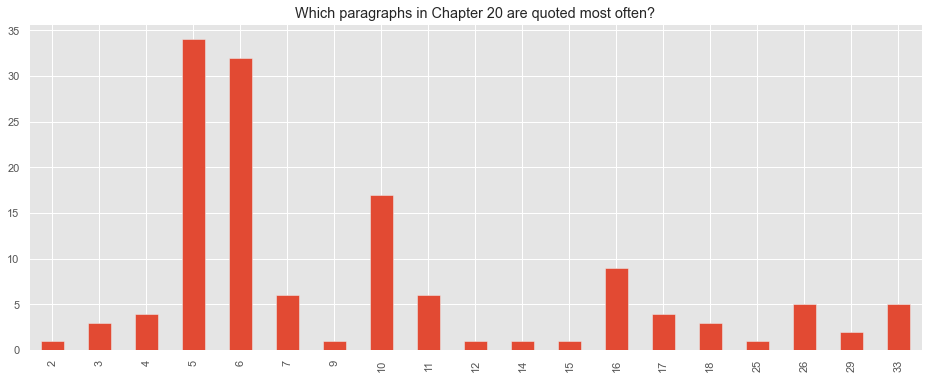

In [500]:
pd.Series(dict(grandTally)).sort_index().plot(kind='bar', title="Which paragraphs in Chapter 20 are quoted most often?")

In [314]:
print(mm[xxParaLocations[5]:xxParaLocations[7]]) # What are paragraphs #5 and #6? 



To those who have looked at Rome with the quickening power of a
knowledge which breathes a growing soul into all historic shapes, and
traces out the suppressed transitions which unite all contrasts, Rome
may still be the spiritual centre and interpreter of the world.  But
let them conceive one more historical contrast: the gigantic broken
revelations of that Imperial and Papal city thrust abruptly on the
notions of a girl who had been brought up in English and Swiss
Puritanism, fed on meagre Protestant histories and on art chiefly of
the hand-screen sort; a girl whose ardent nature turned all her small
allowance of knowledge into principles, fusing her actions into their
mould, and whose quick emotions gave the most abstract things the
quality of a pleasure or a pain; a girl who had lately become a wife,
and from the enthusiastic acceptance of untried duty found herself
plunged in tumultuous preoccupation with her personal lot.  The weight
of unintelligible Rome might lie easily on b

# *Middlemarch* Quotations, by Journal

- [Descriptive-statistics-on-journals-in-JSTOR-dataset](#Descriptive-statistics-on-journals-in-JSTOR-dataset)
- [GE-GHLS, NLH, and ELH)](#GE-GHLS,-NLH,-and-ELH)
    - [#George-Eliot---George-Henry-Lewes-Studies-(GE-GHLS)](#George-Eliot---George-Henry-Lewes-Studies-(GE-GHLS))
    - [#George-Eliot---George-Henry-Lewes-Studies-articles-where-journal-title-is-"George-Eliot---George-Henry-Lewes-Studies"](#George-Eliot---George-Henry-Lewes-Studies-articles-where-journal-title-is-"George-Eliot---George-Henry-Lewes-Studies")
    - [#George-Eliot---George-Henry-Lewes-Studies-articles-where-journal-code-is-"georelioghlstud"](#George-Eliot---George-Henry-Lewes-Studies-articles-where-journal-code-is-"georelioghlstud")
    - [#Compare-the-specialist-journal,-George-Eliot---George-Henry-Lewes-Studies,-with-all-other-journals](#Compare-the-specialist-journal,-George-Eliot---George-Henry-Lewes-Studies,-with-all-other-journals)
- [NLH](#NLH)
    - [#NLH-articles-where-journal-title-is-"New-Literary-History"](#NLH-articles-where-journal-title-is-"New-Literary-History")
    - [NLH-articles-where-journal-code-is-"newlitehist"](#NLH-articles-where-journal-code-is-"newlitehist")
-[ELH](#ELH)
    - [#ELH-articles-where-journal-title-is-"ELH"](#ELH-articles-where-journal-title-is-"ELH")
    - [#ELH-articles-where-journal-code-is-"elh"](#ELH-articles-where-journal-code-is-"elh")

## Descriptive statistics on journals in JSTOR dataset

In [488]:
# Top 10 journals with most articles in our dataset
journalStats = df['journal'].value_counts()
print("Journal   |    Number of articles in our dataset")
journalStats[:10]

Journal   |    Number of articles in our dataset


Victorian Studies                            424
George Eliot - George Henry Lewes Studies    206
Nineteenth-Century Fiction                   192
The Modern Language Review                   188
The Review of English Studies                185
Nineteenth-Century Literature                126
NOVEL: A Forum on Fiction                    126
Studies in the Novel                         120
Studies in English Literature, 1500-1900      85
ELH                                           77
Name: journal, dtype: int64

In [268]:
journalList = journalStats.index

In [272]:
journals = pd.DataFrame({title: synchronicAnalysis(df.loc[df['journal'] == title]) for title in journalList }).T

In [273]:
cutoff = 1500
topJournals = journals.loc[journals.sum(axis=1) > cutoff]
otherJournals = journals.loc[journals.sum(axis=1) < cutoff]
topJournals.loc['Other'] = otherJournals.sum()

/Users/sceckert/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


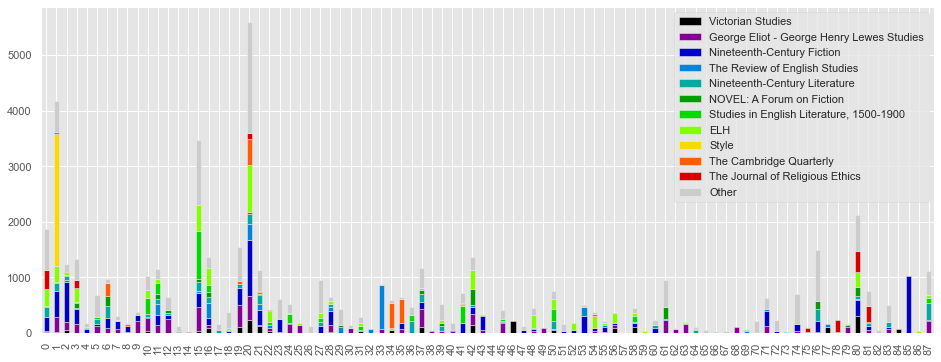

In [274]:
topJournals.T.plot(kind='bar', stacked=True, colormap='nipy_spectral')

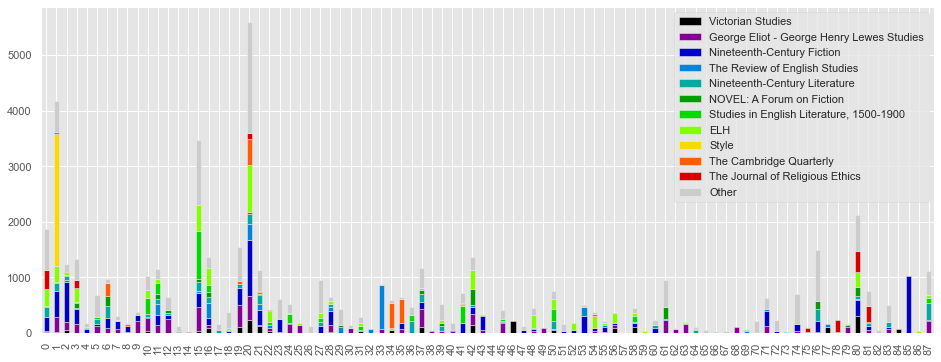

In [275]:
ax = topJournals.T.plot(kind='bar', stacked=True, colormap='nipy_spectral')
fig = ax.get_figure()
fig.savefig('synchronic-journals.png', bboxinches='tight', dpi=300)

In [276]:
# Print the total number of journals
len(journalStats)

365

# *GE-GHLS*, *NLH*, and *ELH* 

## *George Eliot - George Henry Lewes Studies* (*GE-GHLS*)

### George Eliot - George Henry Lewes Studies articles where journal title is "George Eliot - George Henry Lewes Studies"

In [315]:
geJournals = df.loc[df['journal'] == 'George Eliot - George Henry Lewes Studies']

In [316]:
pd.set_option('display.max_columns', 207)

In [317]:
geJournals 

,Locations in A,Locations in B,author,coverdate,disc_name,doi,id,jcode,journal,la,no,numMatches,pages,publisher_name,sp,srcHtml,title,topics,ty,vo,year,Decade,Quoted Words,Locations in A with Wordcounts,Wordcounts,country
7,[],[],[K. K. Collins],[20151101],"[Language & Literature, Humanities]",10.5325/georelioghlstud.67.2.0234,6a9b9119-bfa6-3a6e-82cf-1dccbaefe55b,[georelioghlstud],George Eliot - George Henry Lewes Studies,[eng],[2],1,234-242,[Penn State University Press],234,<cite>George Eliot - George Henry Lewes Studie...,[Review],"[Biography, Masculinity, Pastiche, Textbook re...",brv,[67],2015,2010,0,[],[],US
14,"[[195357, 195597]]","[[27642, 27885]]","[ROSEMARY BRENNAN DAY, GRAHAM HANDLEY, DONALD ...",[19940901],"[Language & Literature, Humanities]",10.2307/42870840,72ab47e3-5bd7-3c8c-a03e-ee9281130e2d,[georelioghlstud],George Eliot - George Henry Lewes Studies,[eng],[26/27],2,36-81,[Penn State University Press],36,<cite>George Eliot - George Henry Lewes Studie...,[MIDDLEMARCH ON TV--A SYMPOSIUM],"[Villains, Humor, Screenwriting, Pity, Soap op...",fla,None,1994,1990,40,"[([195357, 195597], 40)]",[40],US
34,"[[512101, 512375]]","[[9829, 10102]]",[LESLEY GORDON],[19950901],"[Language & Literature, Humanities]",10.2307/43595510,c7b950b2-0669-3b7e-b270-1f5935d046d2,[georelioghlstud],George Eliot - George Henry Lewes Studies,[eng],[28/29],2,30-41,[Penn State University Press],30,<cite>George Eliot - George Henry Lewes Studie...,[GEORGE ELIOT AND PLUTARCH],"[Nightingales, Tyranny, Theater criticism, Nov...",fla,None,1995,1990,49,"[([512101, 512375], 49)]",[49],US
40,[],[],[JOHN R. PFEIFFER],[20070901],"[Language & Literature, Humanities]",10.2307/42827841,4107827d-116a-3e2e-a579-4d68d6549df3,[georelioghlstud],George Eliot - George Henry Lewes Studies,[eng],[52/53],0,144-147,[Penn State University Press],144,<cite>George Eliot - George Henry Lewes Studie...,None,"[Novels, Literary characters, Essayists, Wheel...",brv,None,2007,2000,0,[],[],US
46,"[[79888, 79968], [137185, 137297], [415296, 41...","[[2131, 2207], [3016, 3127], [7459, 7622], [77...",[CHESTER ST. H. MILLS],[19940901],"[Language & Literature, Humanities]",10.2307/42870836,bc692f3b-e2eb-3f26-9285-9203f5d6de48,[georelioghlstud],George Eliot - George Henry Lewes Studies,[eng],[26/27],9,1-6,[Penn State University Press],1,<cite>George Eliot - George Henry Lewes Studie...,"[ELIOT'S SPANISH CONNECTION: CASAUBON, THE AVA...","[Chivalry, Somatosensory perception, Endangere...",fla,None,1994,1990,225,"[([79888, 79968], 14), ([137185, 137297], 24),...","[14, 24, 28, 77, 82]",US
48,[],[],[Claudia Stevens],[20151101],"[Language & Literature, Humanities]",10.5325/georelioghlstud.67.2.0227,6dfa8330-d590-35d4-8e42-5686f97cf016,[georelioghlstud],George Eliot - George Henry Lewes Studies,[eng],[2],0,227-233,[Penn State University Press],227,<cite>George Eliot - George Henry Lewes Studie...,[A New Opera: <em>Middlemarch in Spring</em>],"[Opera, Solos, Orchestras, Uncles, Ragpickers,...",fla,[67],2015,2010,0,[],[],US
49,"[[234173, 234366], [281678, 281814], [539647, ...","[[9325, 9519], [13304, 13440], [13997, 14107],...",[KEITH A. WADDLE],[19950901],"[Language & Literature, Humanities]",10.2307/43595509,8900103f-bb17-38f8-94aa-ad77ca8ca07f,[georelioghlstud],George Eliot - George Henry Lewes Studies,[eng],[28/29],6,16-29,[Penn State University Press],16,<cite>George Eliot - George Henry Lewes Studie...,"[MARY GARTH, THE WOLLSTONECRAFTIAN FEMINIST OF...","[Pity, Women, Passion, Humor, Compassion, Hone...",fla,None,1995,1990,144,"[([234173, 234366], 33), ([281678, 281814], 26...","[33, 26, 20, 42, 23]",US
50,"[[35061, 35262], [51087, 51257], [415296, 4153...","[[6872, 7080], [14564, 14734], [14790, 14890],...",[DAVID L. SMITH],[20010901],"[Language & Literature, Humanities]",10.2307/42827730,4b1f236f-3135-3f7f-b40c-06e7d0e5f309,[georelioghlstud],George Eliot - George Henry Lewes Studies,[eng],[40/41],6,34-46,[Penn State University Press],34,<cite>George Eliot - George Henry Lewes Studie

In [318]:
print(geJournals.title)

7                                                [Review]
14                       [MIDDLEMARCH ON TV--A SYMPOSIUM]
34                            [GEORGE ELIOT AND PLUTARCH]
40                                                   None
46      [ELIOT'S SPANISH CONNECTION: CASAUBON, THE AVA...
48          [A New Opera: <em>Middlemarch in Spring</em>]
49      [MARY GARTH, THE WOLLSTONECRAFTIAN FEMINIST OF...
50             ["MIDDLEMARCH": ELIOT'S TENDER SUBVERSION]
52      [GERMAN-LANGUAGE PUBLICATIONS ON GEORGE ELIOT,...
58             [CARLYLE AND THE PRELUDE TO "MIDDLEMARCH"]
64      [EDITOR'S NOTE: THE LIFE AND WORK OF JEROME BE...
75                                                   None
85                                                   None
86        [ROME IN "MIDDLEMARCH": A NEED FOR FOREIGNNESS]
91      [ART INTO LIFE, LIFE INTO ART: "MIDDLEMARCH" A...
97      [WRITING MARY GARTH: LOCATING MIDDLE GROUND AM...
119                                                  None
120           

In [319]:
print("Number of George ELiot - George Henry Lewes Studies articles where journal title is 'George ELiot - George Henry Lewes Studies':")
len(geJournals)

Number of George ELiot - George Henry Lewes Studies articles where journal title is 'George ELiot - George Henry Lewes Studies':


206

### George Eliot - George Henry Lewes Studies articles where journal code is "georelioghlstud"

In [320]:
print("Number of George Eliot - George Henry Lewes Studies articles where journal code is 'georelioghlstud':")
geJournalCodes = df.loc[df['jcode'].str[0] == 'georelioghlstud']
len(geJournalCodes)

Number of George Eliot - George Henry Lewes Studies articles where journal code is 'georelioghlstud':


206

### Compare the specialist journal, *George Eliot - George Henry Lewes Studies*, with all other journals

In [269]:
geJournals = df.loc[df['journal'] == 'George Eliot - George Henry Lewes Studies']
otherJournals = df.loc[df['journal'] != 'George Eliot - George Henry Lewes Studies']

In [270]:
# Normalize
geDF = synchronicAnalysis(geJournals)
otherDF = synchronicAnalysis(otherJournals)
normGE = geDF.div(geDF.max())
normOther = otherDF.div(otherDF.max())

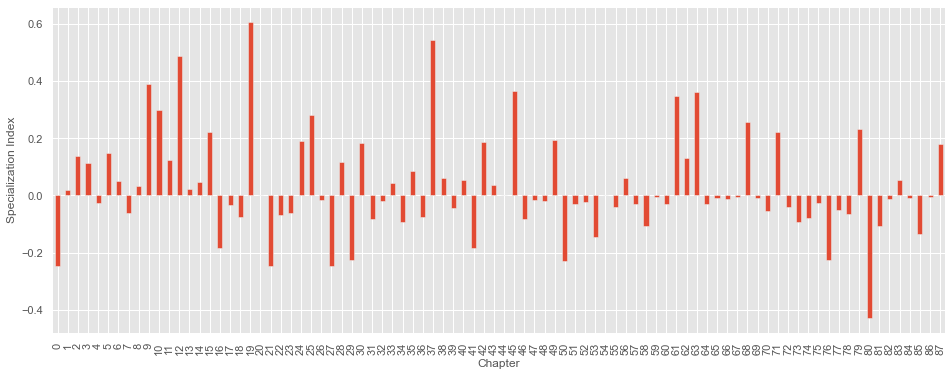

In [271]:
fig = plt.figure()
ax = (normGE - normOther).plot(kind='bar')
fig.add_subplot(ax)
ax.set_xlabel('Chapter')
ax.set_ylabel('Specialization Index')
# Save a big version for publication. 
fig.savefig('specialization.png', bboxinches='tight', dpi=300)

## *NLH*

### NLH articles where journal title is "New Literary History"

In [321]:
nlhJournals = df.loc[df['journal'] == 'New Literary History']

In [322]:
pd.set_option('display.max_rows', 300)

In [323]:
nlhJournals 

,Locations in A,Locations in B,author,coverdate,disc_name,doi,id,jcode,journal,la,no,numMatches,pages,publisher_name,sp,srcHtml,title,topics,ty,vo,year,Decade,Quoted Words,Locations in A with Wordcounts,Wordcounts,country
842,[],[],[Murray Baumgarten],[19750101],"[Language & Literature, Humanities]",10.2307/468428,3bc4df0f-42c8-3779-a157-7dff29faa018,[newlitehist],New Literary History,[eng],[2],0,415-427,[Johns Hopkins University Press],415,"<cite>New Literary History</cite>, Vol. 6, No....",[From Realism to Expressionism: Toward a Histo...,"[Narratology, Expressionism, Impressionism, In...",fla,[6],1975,1970,0,[],[],US
2581,"[[3247, 3495], [13519, 14153]]","[[20342, 20589], [25696, 26322]]","[Ellen Schauber, Ellen Spolsky]",[19810401],"[Language & Literature, Humanities]",10.2307/469021,86c18de4-606e-3c63-9e35-9cbb3151599c,[newlitehist],New Literary History,[eng],[3],3,397-413,[Johns Hopkins University Press],397,"<cite>New Literary History</cite>, Vol. 12, No...",[Stalking a Generative Poetics],"[Sentences, Pragmatics, Poetics, Fables, Inten...",fla,[12],1981,1980,157,"[([3247, 3495], 46), ([13519, 14153], 111)]","[46, 111]",US
2707,"[[1689341, 1689496]]","[[16871, 17026]]",[Eugene Goodheart],[19940401],"[Language & Literature, Humanities]",10.2307/469456,6dd22696-d077-3e1b-bbbf-c428897d443a,[newlitehist],New Literary History,[eng],[2],2,415-428,[Johns Hopkins University Press],415,"<cite>New Literary History</cite>, Vol. 25, No...","[Arnold, Critic of Ideology]","[Objectivity, Idealism, Resentment, Conservati...",fla,[25],1994,1990,26,"[([1689341, 1689496], 26)]",[26],US
3004,[],[],None,[19700101],"[Language & Literature, Humanities]",10.2307/468637,30265440-1009-3bf3-aeb5-df39805ece6f,[newlitehist],New Literary History,[eng],[2],0,None,[Johns Hopkins University Press],None,"<cite>New Literary History</cite>, Vol. 1, No....",[Back Matter],"[Literary criticism, Music criticism, Text edi...",mis,[1],1970,1970,0,[],[],US
3015,[],[],[Robert Coles],[19801001],"[Language & Literature, Humanities]",10.2307/468816,b320dfee-2e66-3b3c-a4a7-0c359597c5c0,[newlitehist],New Literary History,[eng],[1],0,207-211,[Johns Hopkins University Press],207,"<cite>New Literary History</cite>, Vol. 12, No...","[Commentary on ""Psychology and Literature""]","[Poetry, Psychoanalysts, Fantasy fiction, Nove...",fla,[12],1980,1980,0,[],[],US
3089,[],[],[John M. Picker],[20060401],"[Language & Literature, Humanities]",10.2307/20057949,a81f9b21-332d-3e91-911e-a3d070986b3f,[newlitehist],New Literary History,[eng],[2],0,361-388,[Johns Hopkins University Press],361,"<cite>New Literary History</cite>, Vol. 37, No...",[George Eliot and the Sequel Question],"[Parody, Melodrama, Illustration, Pseudonyms, ...",fla,[37],2006,2000,0,[],[],US
3444,[],[],"[E. D. Hirsch, <suffix>Jr.</suffix>]",[19830101],"[Language & Literature, Humanities]",10.2307/468692,9063bc54-0080-3efa-b4c8-b5b1f038541b,[newlitehist],New Literary History,[eng],[2],0,389-397,[Johns Hopkins University Press],389,"<cite>New Literary History</cite>, Vol. 14, No...",[Beyond Convention?],"[Conventionalism, Philosophical realism, Veris...",fla,[14],1983,1980,0,[],[],US
3460,[],[],[Martin Price],[19730101],"[Language & Literature, Humanities]",10.2307/468483,680c7846-2940-3d8c-9c2e-7c1c519b8e78,[newlitehist],New Literary History,[eng],[2],0,381-387,[Johns Hopkins University Press],381,"<cite>New Literary History</cite>, Vol. 4, No....",[Form and Discontent],"[Poetics, Allegory, Actuality, Functionalism, ...",fla,[4],1973,1970,0,[],[],US
3461,[],[],[Hilary Putnam],[19831001],"[Language & Literature, Humanities]",10.2307/469002,38a87c02-9add-37e8-836d-e763f9909bf8,[newlitehist],New Literary History,[eng],[1],1,193-200,[Johns Hopkins University Press],193,"<cite>New Literary History</cite>, Vol. 15, No...",[Taking Rules Seriously: A Response to Martha ...,"[Morality, Happiness, Oppression, Maxims, Laws...",fla,[15],1983,1980,0,[],[],US
3676,[],[],[Elaine Freedgood],[20100401],"[Language & Literature, Humani

In [324]:
print("Number of NLH articles where journal title is 'New Literary History':")
len(nlhJournals)

Number of NLH articles where journal title is 'New Literary History':


24

### NLH articles where journal code is "newlitehist"

In [325]:
print('NLH articles where journal code is "newlitehist":')
nlhJournalCodes = df.loc[df['jcode'].str[0] == 'newlitehist']
len(nlhJournalCodes)

NLH articles where journal code is "newlitehist":


25

## *ELH*

### ELH articles where journal title is "ELH"

In [326]:
elhJournals = df.loc[df['journal'] == 'ELH']
elhJournals

,Locations in A,Locations in B,author,coverdate,disc_name,doi,id,jcode,journal,la,no,numMatches,pages,publisher_name,sp,srcHtml,title,topics,ty,vo,year,Decade,Quoted Words,Locations in A with Wordcounts,Wordcounts,country
19,"[[415187, 415972], [1691326, 1691647]]","[[8469, 9251], [18464, 18785]]",[Janet K. Gezari],[19780401],"[Language & Literature, Humanities]",10.2307/2872453,bdec7777-4547-380f-8567-cb4dbcaa9388,[elh],ELH,[eng],[1],4,93-106,[Johns Hopkins University Press],93,"<cite>ELH</cite>, Vol. 45, No. 1 (Spring, 1978...",[The Metaphorical Imagination of George Eliot],"[Novels, Sympathy, Travel, Dialectic, Allegory...",fla,[45],1978,1970,188,"[([415187, 415972], 129), ([1691326, 1691647],...","[129, 59]",US
26,"[[698796, 699017], [1368267, 1368353], [169094...","[[15380, 15597], [29093, 29180], [40262, 40962]]",[Brian Swann],[19720601],"[Language & Literature, Humanities]",10.2307/2872247,af76839c-e17f-336c-a45b-7e2a150cf963,[elh],ELH,[eng],[2],4,279-308,[Johns Hopkins University Press],279,"<cite>ELH</cite>, Vol. 39, No. 2 (Jun., 1972),...",[Middlemarch: Realism and Symbolic Form],"[Synecdoche, Irony, Pity, Symbolism, Chivalry,...",fla,[39],1972,1970,181,"[([698796, 699017], 38), ([1368267, 1368353], ...","[38, 13, 130]",US
28,"[[18311, 18654], [36712, 36879], [39525, 39677...","[[9299, 9639], [13482, 13644], [22259, 22414],...",[Sophia Andres],[19881201],"[Language & Literature, Humanities]",10.2307/2873139,682a0b66-d9b2-305c-99dd-22cd29b16067,[elh],ELH,[eng],[4],16,853-868,[Johns Hopkins University Press],853,"<cite>ELH</cite>, Vol. 55, No. 4 (Winter, 1988...",[The Germ and the Picture in Middlemarch],"[Labyrinths, Preludes, Diastole, Harps, Curtai...",fla,[55],1988,1980,422,"[([18311, 18654], 61), ([36712, 36879], 31), (...","[61, 31, 22, 37, 18, 11, 16, 22, 28, 13, 57, 1...",US
72,"[[291679, 291940], [297602, 297690], [307281, ...","[[1777, 2037], [4485, 4590], [5770, 5987], [61...",[Jeremy Tambling],[19901201],"[Language & Literature, Humanities]",10.2307/2873091,4754a86e-dbdb-3cf2-aa1a-0179494fcc8c,[elh],ELH,[eng],[4],12,939-960,[Johns Hopkins University Press],939,"<cite>ELH</cite>, Vol. 57, No. 4 (Winter, 1990...","[Middlemarch, Realism and the Birth of the Cli...","[Metonymy, Constructive empiricism, Positivism...",fla,[57],1990,1990,388,"[([291679, 291940], 45), ([297602, 297690], 14...","[45, 14, 38, 17, 46, 39, 62, 69, 33, 25]",US
105,"[[6270, 6426], [297998, 298358], [828586, 8289...","[[21578, 21733], [29548, 29905], [43000, 43317...",[J. Jeffrey Franklin],[19941201],"[Language & Literature, Humanities]",10.2307/2873363,1bc977c7-5773-3298-affd-38bc079ca44b,[elh],ELH,[eng],[4],5,899-921,[Johns Hopkins University Press],899,"<cite>ELH</cite>, Vol. 61, No. 4 (Winter, 1994...",[The Victorian Discourse of Gambling: Speculat...,"[Gambling, Betting, Vicars, Scapegoats, Stockb...",fla,[61],1994,1990,182,"[([6270, 6426], 25), ([297998, 298358], 65), (...","[25, 65, 59, 33]",US
131,"[[888787, 888912], [1175936, 1176366], [120672...","[[1790, 1915], [15106, 15538], [27756, 28265],...",[Jessie Givner],[20020401],"[Language & Literature, Humanities]",10.2307/30032017,f3c82cfe-9c11-397a-88db-e0ca9e940bbb,[elh],ELH,[eng],[1],5,223-243,[Johns Hopkins University Press],223,"<cite>ELH</cite>, Vol. 69, No. 1 (Spring, 2002...","[Industrial History, Preindustrial Literature:...","[Personification, Fetishism, Artistic realism,...",fla,[69],2002,2000,216,"[([888787, 888912], 19), ([1175936, 1176366], ...","[19, 74, 93, 30]",US
156,"[[11700, 11779], [40138, 40450], [48998, 49711...","[[5441, 5520], [6026, 6337], [20063, 20772], [...",[Michael Peled Ginsburg],[19801001],"[Language & Literature, Humanities]",10.2307/2872795,7374e142-9fdd-3f05-b302-fd879956047b,[elh],ELH,[eng],[3],11,542-558,[Johns Hopkins University Press],542,"<cite>ELH</cite>, Vol. 47, No. 3 (Autumn, 1980...","[Pseudonym, Epigraphs, and Narrative Voice: Mi...","[Literary epigraphs, Narratology, Narrators, P...",fla,[47],1980,1980,525,"[([11700, 11779], 14), ([4

In [327]:
len(elhJournals)

77

### ELH articles where journal code is "elh"

In [328]:
elhJournalCodes = df.loc[df['jcode'].str[0] == 'elh']
len(elhJournalCodes)

85

# Evaluation

## Generating samples of dataset for evaluating the precision and recall of text matcher
First, we're going to generate a smaller sample dataset, which we'll then perform bootstrapping on.

First, let's stratify our dataset by year, and then take a random sample in that year.

In [334]:
articlesWithMatches1960_2015 = articlesWithMatches[articlesWithMatches['Decade'] >= 1960]
len(articlesWithMatches1960_2015)

464

In [335]:
len(articlesWithMatches1960_2015['year'].value_counts())

56

### Generate random sample

In [167]:
sampleData = articlesWithMatches1960_2015.sample(n=56, random_state=56)
sampleData['journal'].value_counts(sort=False)

Modern Philology                             2
Victorian Studies                            3
ELH                                          4
Victorian Literature and Culture             1
George Eliot - George Henry Lewes Studies    4
Texas Studies in Literature and Language     1
The Cambridge Quarterly                      1
Nineteenth-Century Literature                2
Nineteenth-Century Fiction                   8
Poetica                                      1
Studies in the Novel                         1
Feminist Studies                             1
Biography                                    1
The British Journal of Sociology             1
NOVEL: A Forum on Fiction                    1
The Yearbook of English Studies              1
Representations                              1
Name: journal, dtype: int64

In [168]:
sampleData.to_csv('../data/sample_dataset.csv', encoding='utf-8')

In [169]:
# Function to loop over each row, extracting locations in A and metadata, then output that to a new text file
def extractSampleDataMatches(sampleData):
    for i, row in sampleData.iterrows():
        title = row['title']
        year = row['year']
        # Print a break between each article
        with open('../data/sample-data-matches.txt', "a") as f:
            print("---------------------------------------\n", file=f)
            print(title, file=f)
            print(year, file=f)
        # For each pair of locations in the "Locations in A" column, iterate over, printing the location indexes
        # Followed by the text of the match
            for pair in row['Locations in A']:
                print(f"Location in A: {pair}", file=f)
                print(mm[pair[0]:pair[1]]+"\n", file=f)
    
extractSampleDataMatches(sampleData)

### Evaluation metrics

Terminology
TP (True Positives):
TN (True Negatives): 
FP (False Posiives): 
FN (False Negatives): 

**Classification accuracy:** percentage of correctly identified quotes and non-quotes, or overall, how often is the matcher correct? classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)))

 **Recall (or "sensitivity")**: When the actual match is correc, how often is the prediction correct? recall = TP / float(FN + TP)


**Precision:** When a match is detected, how often is that match correct? precision = TP / float(TP + FP)
